# Imports

In [22]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

from exploration import load_datasets, split_data
from scipy.stats import ks_2samp

# Constantes

In [33]:
DATA_FOLDER = "extended_data"

# Utils
Visualización de la similitud entre los conjuntos de entrenamiento y prueba para una la columna específica. Como resultado se obtendrá un DataFrame que combina los datos de ambos conjuntos. De esta forma, evaluar la distribución de una característica particular en los conjuntos de entrenamiento y prueba.

In [35]:
def visualize_train_test_similarity(marca, df_train, df_test, col):
    """Plots similarity for a column between train and test and
    calculates ks statistic"""
    
    df_train_copy = df_train.copy(deep=True)
    df_test_copy = df_test.copy(deep=True)
    
    df_train_copy['split'] = 'train'
    df_test_copy['split'] = 'test'
    
    df_train_test = pd.concat([
        df_train_copy,
        df_test_copy
    ])
    title = (
        f"Comparison of {col} for marca: {marca}" if marca != "muelle"
        else f"Comparison of {col} for all marcas as one"
    )
    plt.figure(figsize=(5,5))
    plt.title(title)
    plt.hist(
        df_train_copy[col],
        label="train",
        density=True,
        bins=30,
        histtype=u'step'
    )
    plt.hist(
        df_test_copy[col],
        label="test",
        density=True,
        bins=30,
        histtype=u'step'
    )
    plt.hist(
        df_train_test[col],
        label="original",
        density=True,
        bins=30,
        histtype=u'step'
    )    
    plt.legend(loc="best")
    plt.show()
    plt.close()
    
    return df_train_test

Calculando y devolviendo estadísticas KS y los valores p para evaluar la similitud entre las distribuciones de columnas numéricas en los conjuntos de entrenamiento y prueba. Con el fin de validar si las distribuciones de las características son similares o diferentes entre los dos conjuntos de datos.

In [36]:
def calculate_ks_statistics(df_train, df_test, num_cols):
    """Calculates kolmogorov-smirnov statistic and pvalue for numerical columns"""
    all_ks_stats = []
    for col in num_cols:
        x_train = df_train[col]
        x_test = df_test[col]
        ks_result = ks_2samp(x_train, x_test)
        ks_statistic = ks_result.statistic
        ks_pvalue = ks_result.pvalue
        ks_col_stats = {
            "col": col,
            "ks_statistic": ks_statistic,
            "ks_pvalue": ks_pvalue
        }
        all_ks_stats.append(ks_col_stats)
    return pd.DataFrame(all_ks_stats)

Análisis detallado de la distribución de datos de para una marca específica en los conjuntos de entrenamiento y prueba, incluyendo visualizaciones de similitud y estadísticas KS para las columnas numéricas. Verificando adicionalmente, cómo los datos de la marca se comportan en diferentes conjuntos y detectar posibles diferencias o desviaciones.

In [37]:
def analyze_marca_splits(marca, marca_splits, num_cols):
    print("*" * 100)
    print("*" * 100)
    print(f"DISTRIBUTION CHANGES FOR MARCA: {marca}")
   
    df_train = marca_splits["X_train"]
    df_test = marca_splits["X_test"]

    display_cols = deepcopy(NUMERICAL_COLUMNS)
    display_cols.extend(["split"])
    for col in num_cols:
        df_splits = visualize_train_test_similarity(
            marca,
            df_train,
            df_test,
            col
        )
    print(f"Train statistics")        
    display(
        df_train.describe()
    )
    print(f"Test statistics")        
    display(
        df_test.describe()
    )
    print(f"Original statistics")        
    display(
        df_splits.describe()
    )
    print(f"KS test statistics")
    display(
        calculate_ks_statistics(
            df_train,
            df_test,
            num_cols
        )
    )
    print("*" * 100)
    print("*" * 100)
    print("\n" * 5)

# Ejecucion

## Lectura de estadisticos para comparar con metricas de modelo
Calculando estadísticas descriptivas para "valor_venta" y muestra estas estadísticas en la tabla. Si se encuentra un archivo que no cumple con los requisitos, se omite sin causar una interrupción en el proceso.

In [27]:
for filename in os.listdir():
    try:
        print(filename)
        display(pd.read_parquet(f"extended_data/{filename}")["valor_venta"].describe(
            percentiles=[0.05,0.2,0.5,0.7,0.95]
        ).to_frame())
    except:
        continue

.ipynb_checkpoints
10_Seleccion_de_mejores_modelos_con_colinealidad.ipynb
1_Limpieza_datos_comerciales.ipynb
2_limpieza_datos_operativos.ipynb
3_Union_datos_operativos_y_comerciales_por_muelle.ipynb
4_Union_de_datos_operativos_y_comerciales_por_marca.ipynb
5_Baselined_de_modelo_de_regresion.ipynb
6_Extension_de_datos_de_pais.ipynb
7_Exploracion_de_hparams.ipynb
8_estadisticos_de_venta_por_marca.ipynb
9_Seleccion_de_mejores_modelos.ipynb
config.py
config_extended_columns.py
data
exploration.py
extended_data
extended_data_results
final_models
model_pruning.py
multivariate_utils.py
raw_data
README.md
results
univariate_utils.py
utils.py
utils_functions.py
__pycache__


## Carga de datasets

In [43]:
datasets = load_datasets()

## Split de datasets en train/test
La validacion se hace con Cross-Validation

In [44]:
for dataset, df_dataset in datasets.items():
    datasets[dataset] = split_data(
        df_dataset
    )

## Extraccion de columnas numericas


In [45]:
NUMERICAL_COLUMNS = datasets["muelle"]["X_train"].select_dtypes(include=np.number).columns.tolist()

In [46]:
NUMERICAL_COLUMNS

['Hora entera',
 'Pasajeros saliendo',
 'Semana',
 'Mes',
 'Día',
 'Hdi2021',
 'Minuto entero',
 'sin_Semana',
 'cos_Semana',
 'sin_Mes',
 'cos_Mes',
 'sin_Día',
 'cos_Día',
 'sin_Hora entera',
 'cos_Hora entera']

## Visualizacion de diferencias de distribucion entre train test y datos originales
No se tiene conjunto de validacion, porque este se genera internamente en la validacion cruzada de los modelos. No obstante, si este split en train-test genera resultados similares entre train, test y original, lo mas probable es que el conjunto de validacion tenga la misma naturaleza debido a que la estrategia de splits en cross validacion es K-fold.

****************************************************************************************************
****************************************************************************************************
DISTRIBUTION CHANGES FOR MARCA: muelle


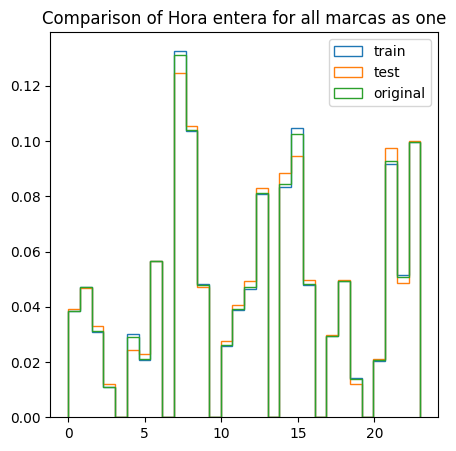

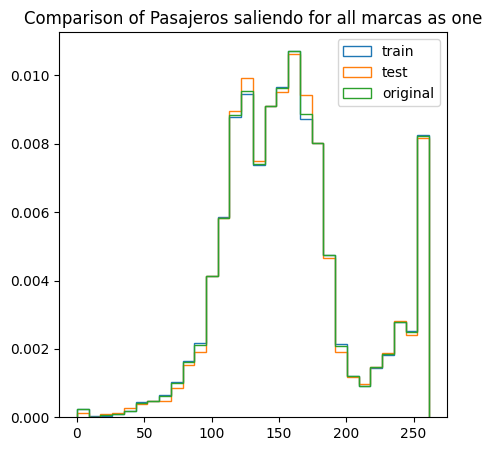

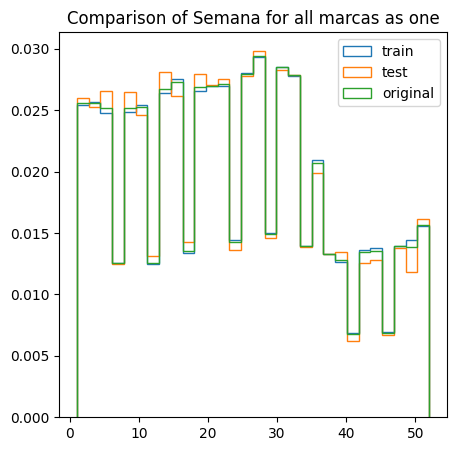

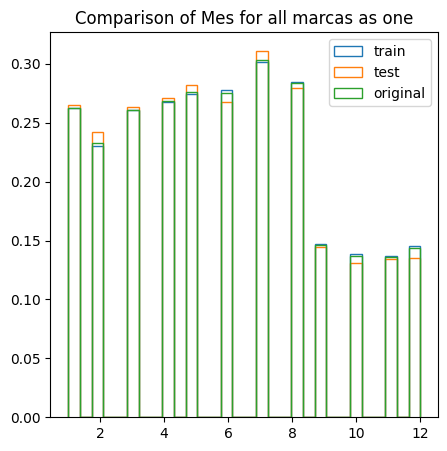

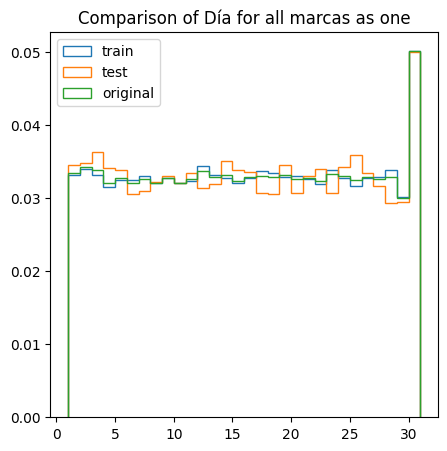

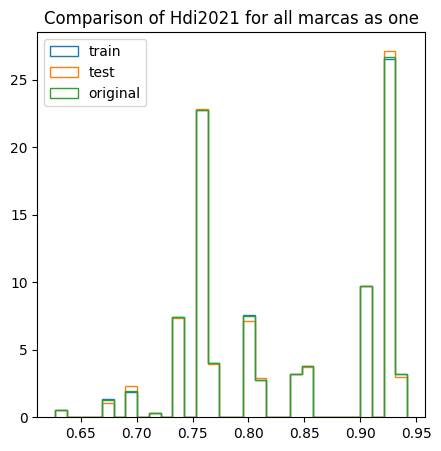

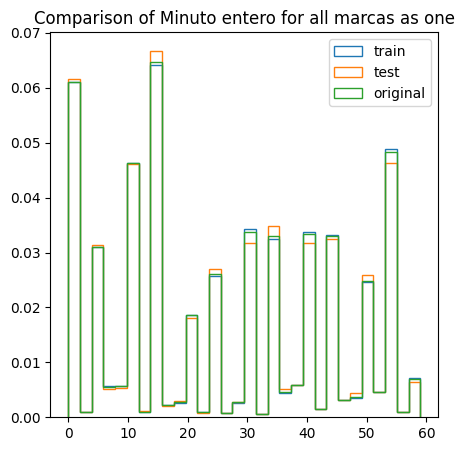

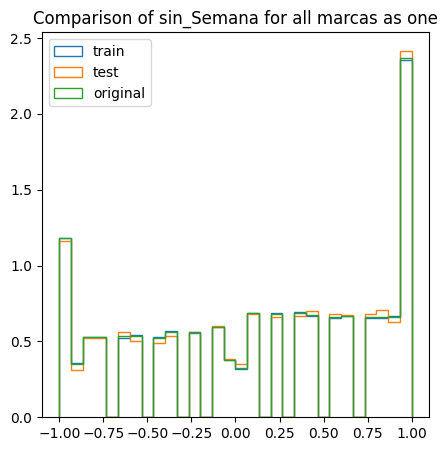

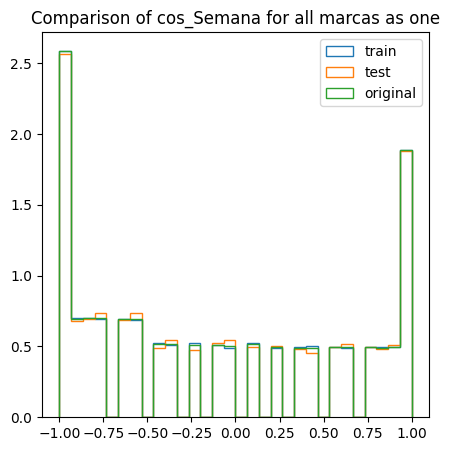

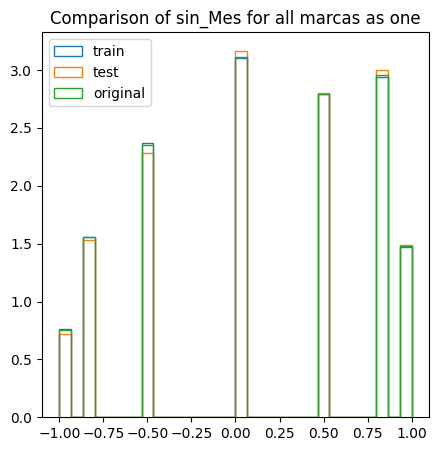

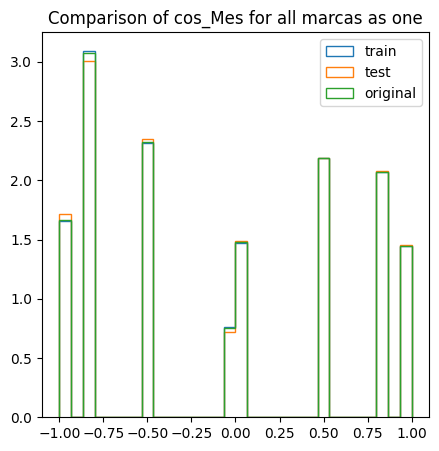

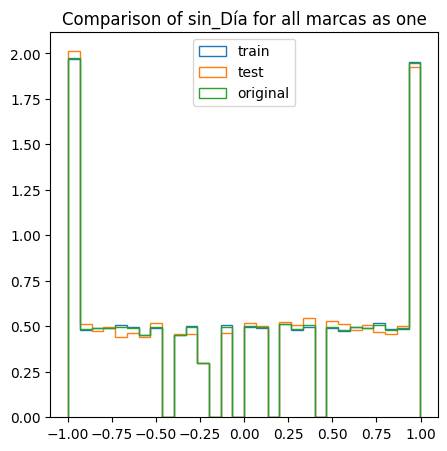

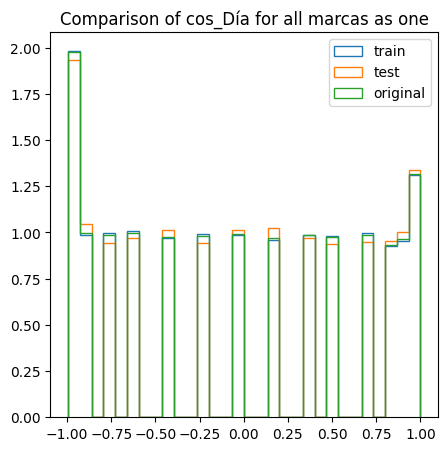

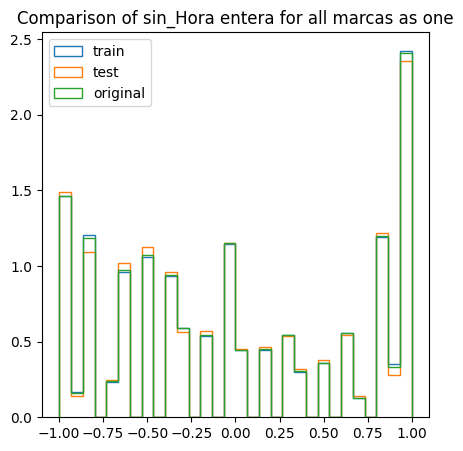

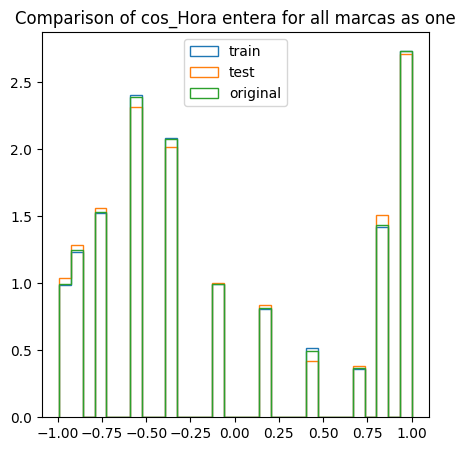

Train statistics


,Hora entera,Pasajeros saliendo,Semana,Mes,Día,Hdi2021,Minuto entero,sin_Semana,cos_Semana,sin_Mes,cos_Mes,sin_Día,cos_Día,sin_Hora entera,cos_Hora entera
count,40267.000000,40267.000000,40267.000000,40267.000000,40267.000000,40267.000000,40267.000000,40267.000000,40267.000000,4.026700e+04,4.026700e+04,40267.000000,40267.000000,4.026700e+04,40267.000000
mean,12.358631,158.397770,23.636005,5.852013,15.739961,0.832319,26.212904,0.128128,-0.096211,1.417070e-01,-7.808787e-02,0.003801,-0.017648,5.879655e-03,-0.059081
std,6.603741,48.484599,13.874898,3.175808,8.810426,0.080067,18.525080,0.672457,0.722601,6.634113e-01,7.305690e-01,0.710750,0.703231,6.869155e-01,0.724325
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.627000,0.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,-0.998717,-0.994869,-9.976688e-01,-0.990686
25%,7.000000,125.000000,12.000000,3.000000,8.000000,0.758000,10.000000,-0.464723,-0.822984,-5.000000e-01,-8.660254e-01,-0.724793,-0.758758,-6.310879e-01,-0.576680
50%,13.000000,153.000000,23.000000,6.000000,16.000000,0.809000,25.000000,0.239316,-0.239316,1.224647e-16,-1.836970e-16,0.000000,-0.050649,-2.449294e-16,-0.334880
75%,18.000000,180.000000,33.000000,8.000000,23.000000,0.921000,42.000000,0.748511,0.663123,8.660254e-01,5.000000e-01,0.724793,0.688967,8.169699e-01,0.854419
max,23.000000,261.500000,52.000000,12.000000,31.000000,0.942000,59.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,0.998717,1.000000,9.976688e-01,1.000000


Test statistics


,Hora entera,Pasajeros saliendo,Semana,Mes,Día,Hdi2021,Minuto entero,sin_Semana,cos_Semana,sin_Mes,cos_Mes,sin_Día,cos_Día,sin_Hora entera,cos_Hora entera
count,10067.000000,10067.000000,10067.000000,10067.000000,10067.000000,10067.000000,10067.000000,10067.000000,10067.000000,1.006700e+04,1.006700e+04,10067.000000,10067.000000,1.006700e+04,10067.000000
mean,12.388199,158.607182,23.311910,5.782358,15.616370,0.832618,26.005861,0.141698,-0.096480,1.532038e-01,-7.627892e-02,0.005387,-0.011496,5.679226e-04,-0.060283
std,6.605687,47.891025,13.795844,3.155991,8.841331,0.080195,18.446320,0.670419,0.721975,6.599032e-01,7.316655e-01,0.710230,0.703925,6.814903e-01,0.729408
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.627000,0.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,-0.998717,-0.994869,-9.976688e-01,-0.990686
25%,7.000000,125.000000,12.000000,3.000000,8.000000,0.758000,10.000000,-0.464723,-0.822984,-5.000000e-01,-8.660254e-01,-0.724793,-0.758758,-6.310879e-01,-0.775711
50%,13.000000,153.000000,23.000000,6.000000,16.000000,0.809000,25.000000,0.239316,-0.239316,1.224647e-16,-1.836970e-16,0.000000,-0.050649,-2.449294e-16,-0.334880
75%,18.000000,180.000000,33.000000,8.000000,23.000000,0.921000,40.000000,0.748511,0.663123,8.660254e-01,5.000000e-01,0.724793,0.688967,8.169699e-01,0.854419
max,23.000000,261.500000,52.000000,12.000000,31.000000,0.942000,59.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,0.998717,1.000000,9.976688e-01,1.000000


Original statistics


,Hora entera,Pasajeros saliendo,Semana,Mes,Día,Hdi2021,Minuto entero,sin_Semana,cos_Semana,sin_Mes,cos_Mes,sin_Día,cos_Día,sin_Hora entera,cos_Hora entera
count,50334.000000,50334.000000,50334.000000,50334.000000,50334.000000,50334.000000,50334.000000,50334.000000,50334.000000,5.033400e+04,5.033400e+04,50334.000000,50334.000000,5.033400e+04,50334.000000
mean,12.364545,158.439653,23.571184,5.838082,15.715242,0.832379,26.171494,0.130842,-0.096265,1.440064e-01,-7.772607e-02,0.004118,-0.016418,4.817287e-03,-0.059322
std,6.604075,48.366064,13.859592,3.171946,8.816666,0.080092,18.509357,0.672065,0.722469,6.627206e-01,7.307815e-01,0.710639,0.703367,6.858304e-01,0.725337
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.627000,0.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,-0.998717,-0.994869,-9.976688e-01,-0.990686
25%,7.000000,125.000000,12.000000,3.000000,8.000000,0.758000,10.000000,-0.464723,-0.822984,-5.000000e-01,-8.660254e-01,-0.724793,-0.758758,-6.310879e-01,-0.775711
50%,13.000000,153.000000,23.000000,6.000000,16.000000,0.809000,25.000000,0.239316,-0.239316,1.224647e-16,-1.836970e-16,0.000000,-0.050649,-2.449294e-16,-0.334880
75%,18.000000,180.000000,33.000000,8.000000,23.000000,0.921000,41.750000,0.748511,0.663123,8.660254e-01,5.000000e-01,0.724793,0.688967,8.169699e-01,0.854419
max,23.000000,261.500000,52.000000,12.000000,31.000000,0.942000,59.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,0.998717,1.000000,9.976688e-01,1.000000


KS test statistics


,col,ks_statistic,ks_pvalue
0,Hora entera,0.006439,0.889970
1,Pasajeros saliendo,0.009515,0.456651
2,Semana,0.011933,0.199985
3,Mes,0.010120,0.378950
4,Día,0.009209,0.498827
5,Hdi2021,0.005058,0.985512
6,Minuto entero,0.007731,0.718390
7,sin_Semana,0.010842,0.297948
8,cos_Semana,0.004923,0.989285
9,sin_Mes,0.009941,0.401045


****************************************************************************************************
****************************************************************************************************






****************************************************************************************************
****************************************************************************************************
DISTRIBUTION CHANGES FOR MARCA: marca 1


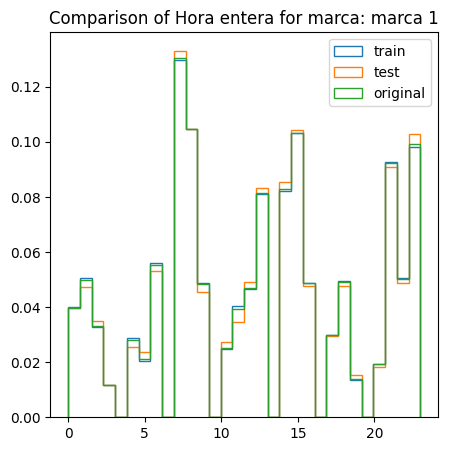

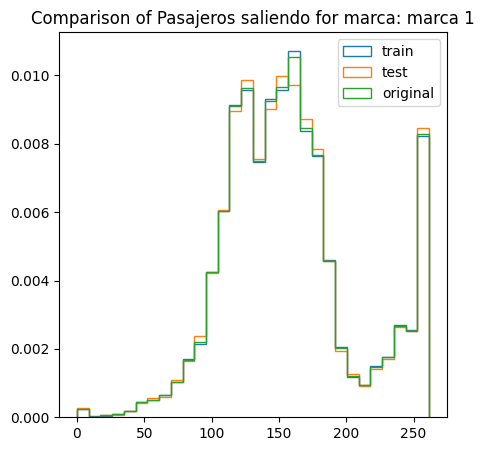

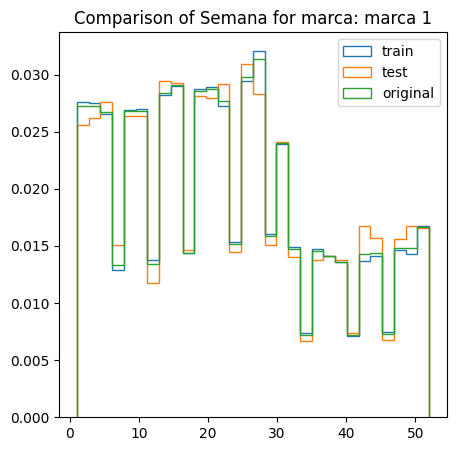

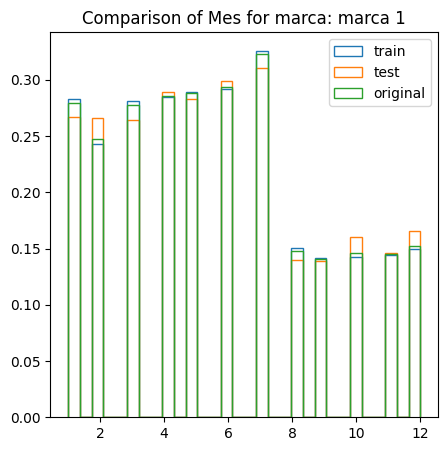

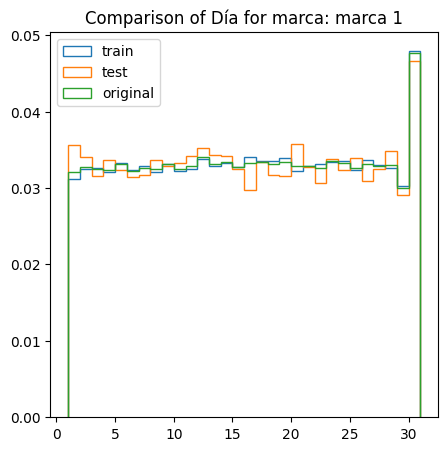

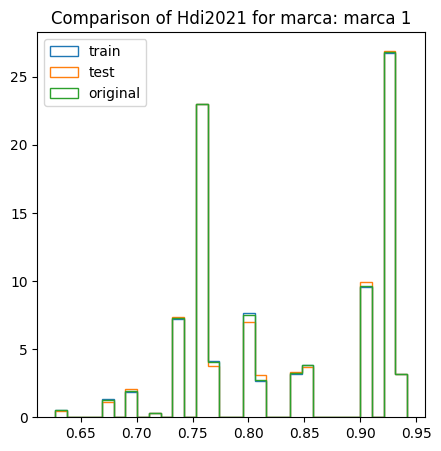

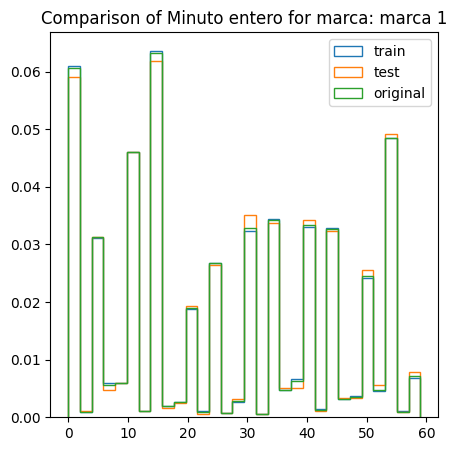

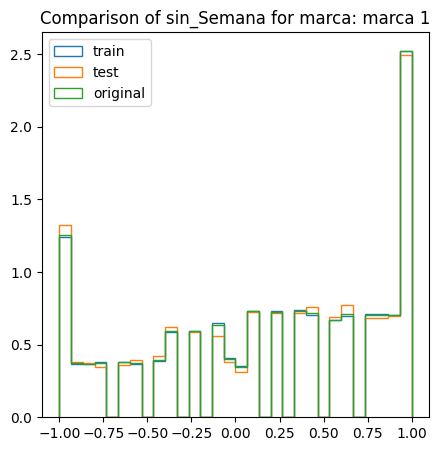

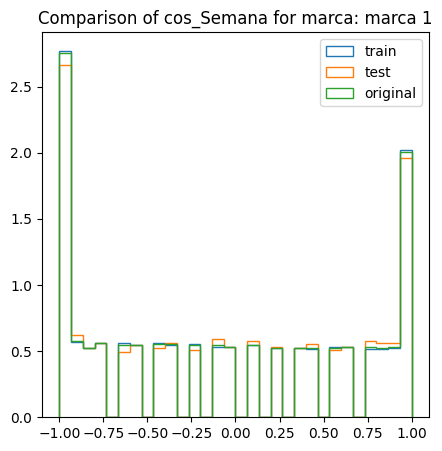

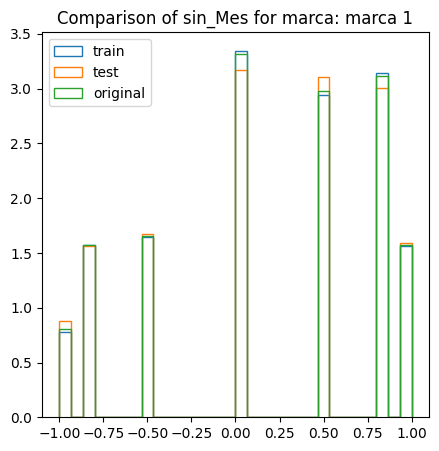

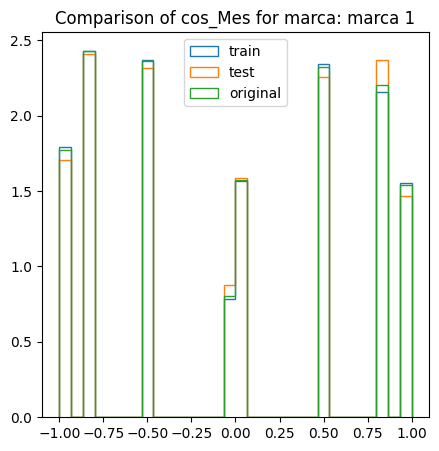

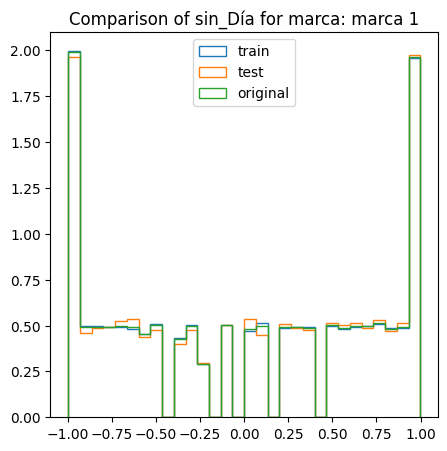

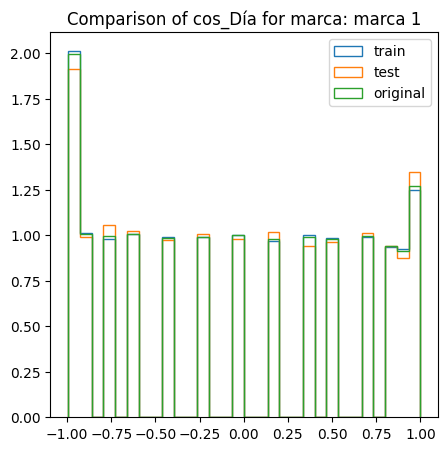

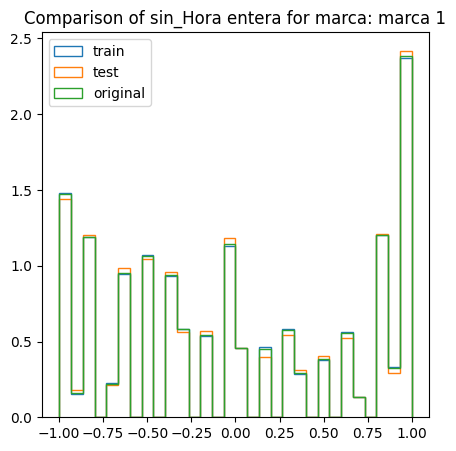

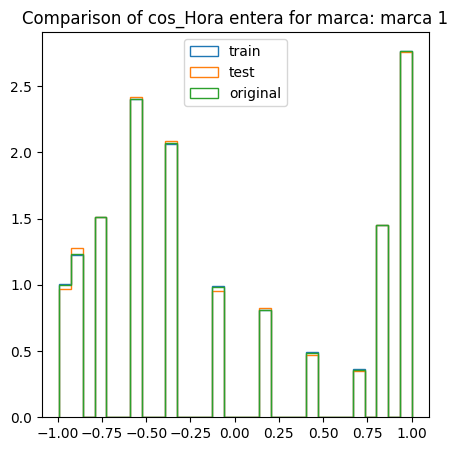

Train statistics


,Hora entera,Pasajeros saliendo,Semana,Mes,Día,Hdi2021,Minuto entero,sin_Semana,cos_Semana,sin_Mes,cos_Mes,sin_Día,cos_Día,sin_Hora entera,cos_Hora entera
count,37850.000000,37850.000000,37850.000000,37850.000000,37850.000000,37850.000000,37850.000000,37850.000000,37850.000000,37850.000000,3.785000e+04,37850.000000,37850.000000,3.785000e+04,37850.000000
mean,12.299234,157.740925,22.929934,5.688428,15.767768,0.832402,26.160793,0.180037,-0.057902,0.185893,-3.257489e-02,0.002840,-0.025945,5.491613e-03,-0.055179
std,6.632658,48.585934,14.051755,3.211147,8.752715,0.079955,18.491786,0.660975,0.726203,0.658964,7.281310e-01,0.712807,0.700894,6.847493e-01,0.726684
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.627000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-0.998717,-0.994869,-9.976688e-01,-0.990686
25%,7.000000,124.000000,11.000000,3.000000,8.000000,0.758000,10.000000,-0.354605,-0.822984,-0.500000,-8.660254e-01,-0.724793,-0.758758,-6.310879e-01,-0.576680
50%,13.000000,152.000000,22.000000,5.000000,16.000000,0.809000,25.000000,0.239316,-0.120537,0.500000,6.123234e-17,0.000000,-0.050649,-2.449294e-16,-0.334880
75%,17.000000,180.000000,32.000000,8.000000,23.000000,0.921000,41.000000,0.822984,0.663123,0.866025,5.000000e-01,0.724793,0.688967,8.169699e-01,0.854419
max,23.000000,261.500000,52.000000,12.000000,31.000000,0.942000,59.000000,1.000000,1.000000,1.000000,1.000000e+00,0.998717,1.000000,9.976688e-01,1.000000


Test statistics


,Hora entera,Pasajeros saliendo,Semana,Mes,Día,Hdi2021,Minuto entero,sin_Semana,cos_Semana,sin_Mes,cos_Mes,sin_Día,cos_Día,sin_Hora entera,cos_Hora entera
count,9463.000000,9463.000000,9463.000000,9463.000000,9463.000000,9463.000000,9463.000000,9463.000000,9463.000000,9463.000000,9.463000e+03,9463.000000,9463.000000,9.463000e+03,9463.000000
mean,12.334989,157.643031,23.216105,5.750079,15.623058,0.833127,26.544753,0.174080,-0.045697,0.178032,-2.019979e-02,0.010427,-0.019543,4.449141e-03,-0.058748
std,6.619694,48.806390,14.202111,3.252918,8.790646,0.079924,18.529435,0.665914,0.724064,0.664383,7.256684e-01,0.712954,0.700937,6.846144e-01,0.726593
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.627000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-0.998717,-0.994869,-9.976688e-01,-0.990686
25%,7.000000,124.000000,11.000000,3.000000,8.000000,0.758000,10.000000,-0.354605,-0.822984,-0.500000,-8.660254e-01,-0.724793,-0.758758,-6.310879e-01,-0.576680
50%,13.000000,152.000000,22.000000,5.000000,15.000000,0.809000,25.000000,0.239316,-0.120537,0.500000,6.123234e-17,0.000000,-0.050649,-2.449294e-16,-0.334880
75%,17.000000,180.000000,33.000000,8.000000,23.000000,0.921000,44.000000,0.822984,0.663123,0.866025,8.660254e-01,0.724793,0.688967,8.169699e-01,0.854419
max,23.000000,261.500000,52.000000,12.000000,31.000000,0.942000,59.000000,1.000000,1.000000,1.000000,1.000000e+00,0.998717,1.000000,9.976688e-01,1.000000


Original statistics


,Hora entera,Pasajeros saliendo,Semana,Mes,Día,Hdi2021,Minuto entero,sin_Semana,cos_Semana,sin_Mes,cos_Mes,sin_Día,cos_Día,sin_Hora entera,cos_Hora entera
count,47313.000000,47313.000000,47313.000000,47313.000000,47313.000000,47313.000000,47313.000000,47313.000000,47313.000000,47313.000000,4.731300e+04,47313.000000,47313.000000,4.731300e+04,47313.000000
mean,12.306385,157.721345,22.987171,5.700759,15.738824,0.832547,26.237588,0.178845,-0.055461,0.184320,-3.009976e-02,0.004357,-0.024665,5.283110e-03,-0.055893
std,6.630012,48.629606,14.082271,3.219605,8.760413,0.079948,18.499764,0.661963,0.725785,0.660052,7.276483e-01,0.712835,0.700899,6.847152e-01,0.726660
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.627000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-0.998717,-0.994869,-9.976688e-01,-0.990686
25%,7.000000,124.000000,11.000000,3.000000,8.000000,0.758000,10.000000,-0.354605,-0.822984,-0.500000,-8.660254e-01,-0.724793,-0.758758,-6.310879e-01,-0.576680
50%,13.000000,152.000000,22.000000,5.000000,16.000000,0.809000,25.000000,0.239316,-0.120537,0.500000,6.123234e-17,0.000000,-0.050649,-2.449294e-16,-0.334880
75%,17.000000,180.000000,32.000000,8.000000,23.000000,0.921000,41.000000,0.822984,0.663123,0.866025,5.000000e-01,0.724793,0.688967,8.169699e-01,0.854419
max,23.000000,261.500000,52.000000,12.000000,31.000000,0.942000,59.000000,1.000000,1.000000,1.000000,1.000000e+00,0.998717,1.000000,9.976688e-01,1.000000


KS test statistics


,col,ks_statistic,ks_pvalue
0,Hora entera,0.005704,0.965106
1,Pasajeros saliendo,0.005892,0.953887
2,Semana,0.013332,0.134362
3,Mes,0.012963,0.155649
4,Día,0.010887,0.328563
5,Hdi2021,0.009219,0.537595
6,Minuto entero,0.011361,0.280413
7,sin_Semana,0.010341,0.390463
8,cos_Semana,0.012706,0.171988
9,sin_Mes,0.011983,0.225321


****************************************************************************************************
****************************************************************************************************






****************************************************************************************************
****************************************************************************************************
DISTRIBUTION CHANGES FOR MARCA: marca 2


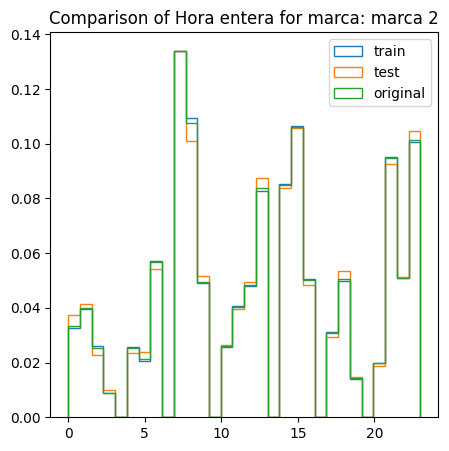

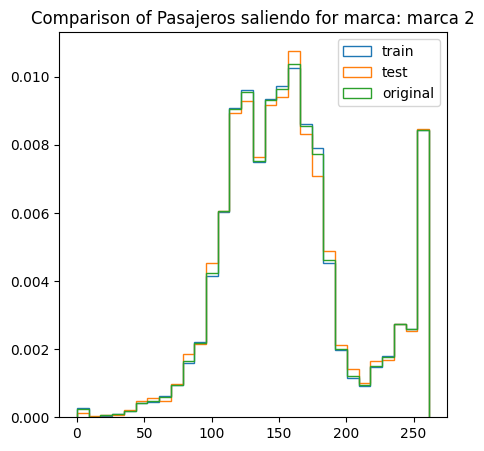

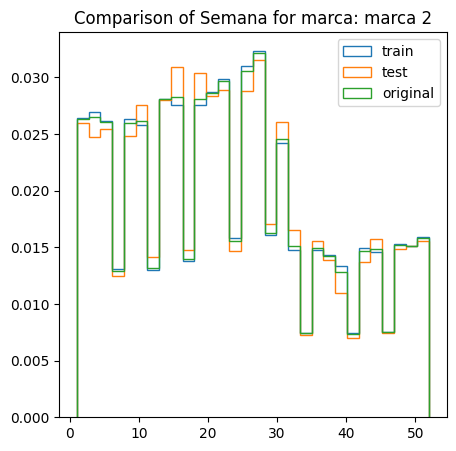

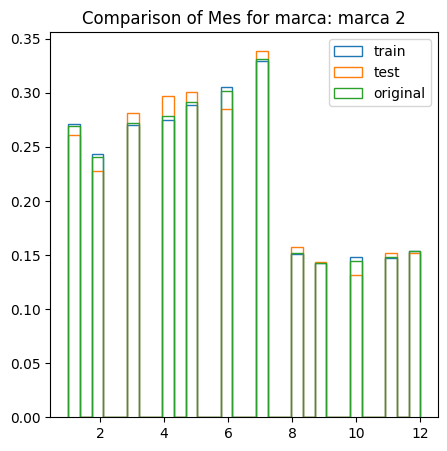

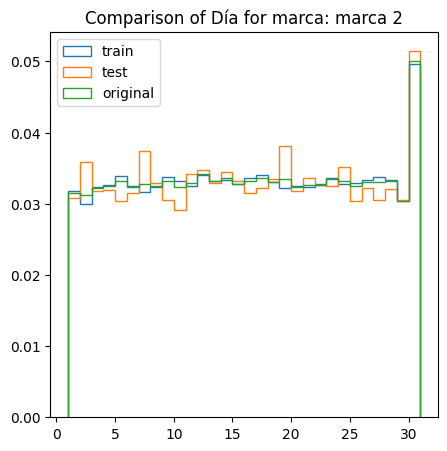

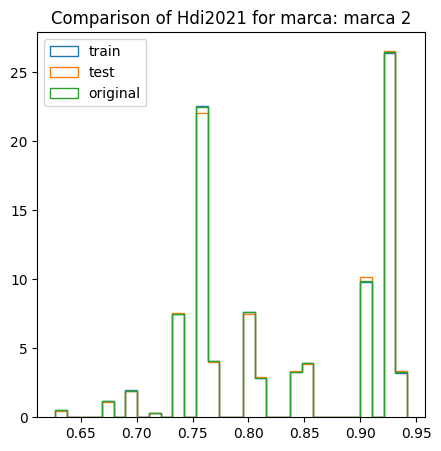

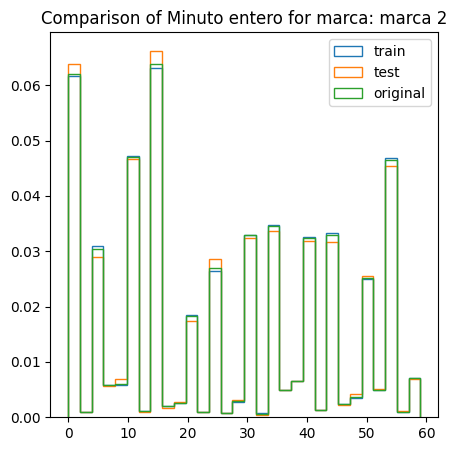

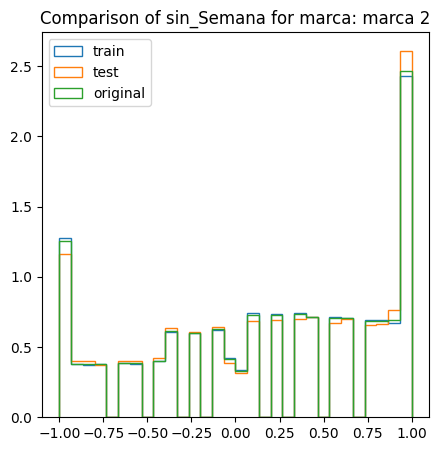

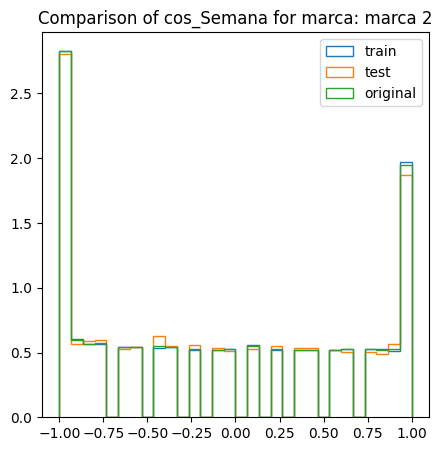

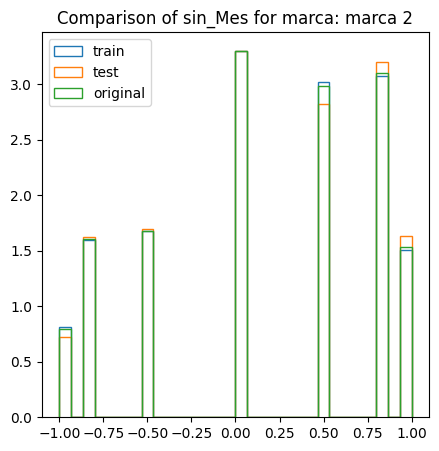

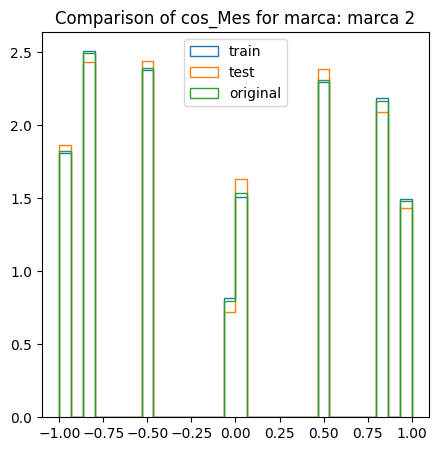

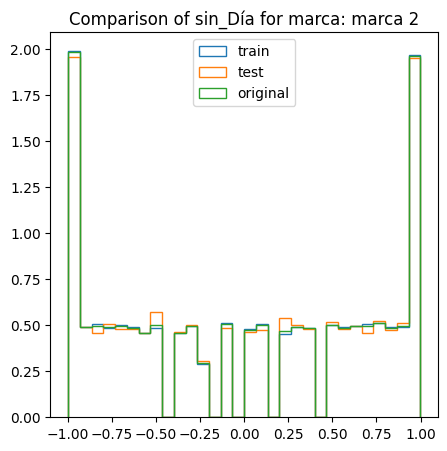

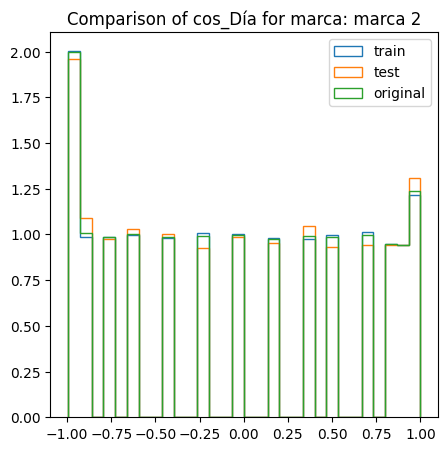

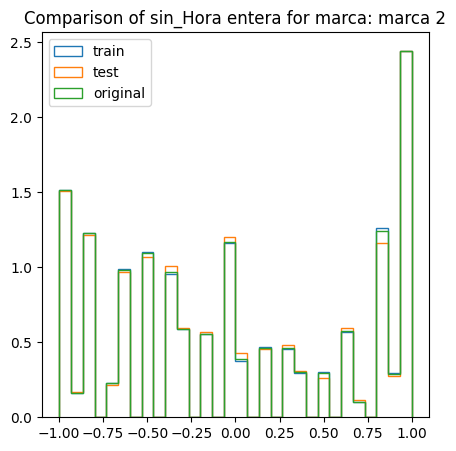

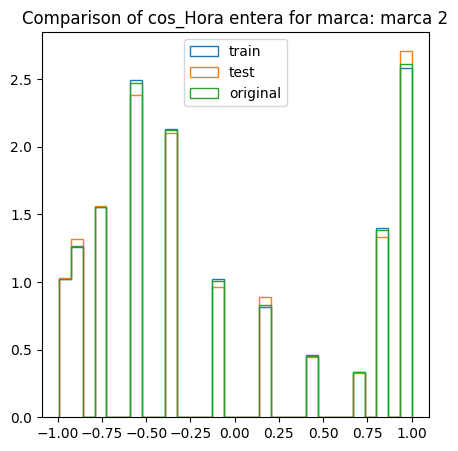

Train statistics


,Hora entera,Pasajeros saliendo,Semana,Mes,Día,Hdi2021,Minuto entero,sin_Semana,cos_Semana,sin_Mes,cos_Mes,sin_Día,cos_Día,sin_Hora entera,cos_Hora entera
count,36809.000000,36809.000000,36809.000000,36809.000000,36809.000000,36809.000000,36809.000000,36809.000000,36809.000000,36809.000000,3.680900e+04,36809.000000,36809.000000,3.680900e+04,36809.000000
mean,12.582167,158.246516,23.196474,5.756608,15.811187,0.832466,26.068733,0.168668,-0.067078,0.176281,-4.281801e-02,0.003911,-0.023588,-4.082303e-03,-0.082603
std,6.462323,48.608070,14.036949,3.213118,8.764099,0.079816,18.471727,0.661233,0.727908,0.660238,7.288367e-01,0.713625,0.700139,6.903788e-01,0.718724
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.627000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-0.998717,-0.994869,-9.976688e-01,-0.990686
25%,7.000000,124.000000,12.000000,3.000000,8.000000,0.758000,10.000000,-0.354605,-0.822984,-0.500000,-8.660254e-01,-0.724793,-0.758758,-6.310879e-01,-0.775711
50%,13.000000,153.000000,22.000000,6.000000,16.000000,0.809000,25.000000,0.239316,-0.120537,0.500000,-1.836970e-16,0.000000,-0.050649,-2.449294e-16,-0.334880
75%,18.000000,180.000000,33.000000,8.000000,23.000000,0.921000,40.000000,0.822984,0.663123,0.866025,5.000000e-01,0.724793,0.688967,8.169699e-01,0.854419
max,23.000000,261.500000,52.000000,12.000000,31.000000,0.942000,59.000000,1.000000,1.000000,1.000000,1.000000e+00,0.998717,1.000000,9.976688e-01,1.000000


Test statistics


,Hora entera,Pasajeros saliendo,Semana,Mes,Día,Hdi2021,Minuto entero,sin_Semana,cos_Semana,sin_Mes,cos_Mes,sin_Día,cos_Día,sin_Hora entera,cos_Hora entera
count,9203.000000,9203.000000,9203.000000,9203.000000,9203.000000,9203.000000,9203.000000,9203.000000,9203.000000,9203.000000,9.203000e+03,9203.000000,9203.000000,9.203000e+03,9203.000000
mean,12.578942,158.241171,23.163099,5.752581,15.757470,0.833880,25.858307,0.179773,-0.075819,0.189078,-5.038915e-02,0.004623,-0.025021,-7.919113e-03,-0.077180
std,6.507877,48.716315,13.912440,3.184223,8.773965,0.079547,18.453508,0.664131,0.721781,0.661714,7.238435e-01,0.709952,0.703867,6.858406e-01,0.723679
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.627000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-0.998717,-0.994869,-9.976688e-01,-0.990686
25%,7.000000,124.000000,12.000000,3.000000,8.000000,0.758000,10.000000,-0.354605,-0.822984,-0.500000,-8.660254e-01,-0.724793,-0.758758,-6.310879e-01,-0.775711
50%,13.000000,153.000000,22.000000,5.000000,16.000000,0.809000,25.000000,0.239316,-0.120537,0.500000,6.123234e-17,0.000000,-0.050649,-2.449294e-16,-0.334880
75%,18.000000,181.000000,32.000000,8.000000,23.000000,0.921000,40.000000,0.822984,0.663123,0.866025,5.000000e-01,0.724793,0.688967,8.169699e-01,0.854419
max,23.000000,261.500000,52.000000,12.000000,31.000000,0.942000,59.000000,1.000000,1.000000,1.000000,1.000000e+00,0.998717,1.000000,9.976688e-01,1.000000


Original statistics


,Hora entera,Pasajeros saliendo,Semana,Mes,Día,Hdi2021,Minuto entero,sin_Semana,cos_Semana,sin_Mes,cos_Mes,sin_Día,cos_Día,sin_Hora entera,cos_Hora entera
count,46012.000000,46012.000000,46012.000000,46012.000000,46012.000000,46012.000000,46012.000000,46012.000000,46012.000000,46012.000000,4.601200e+04,46012.000000,46012.000000,4.601200e+04,46012.000000
mean,12.581522,158.245447,23.189798,5.755803,15.800443,0.832749,26.026645,0.170889,-0.068826,0.178841,-4.433234e-02,0.004054,-0.023875,-4.849715e-03,-0.081518
std,6.471389,48.629210,14.011990,3.207325,8.766004,0.079764,18.468076,0.661821,0.726687,0.660547,7.278392e-01,0.712885,0.700879,6.894678e-01,0.719713
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.627000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-0.998717,-0.994869,-9.976688e-01,-0.990686
25%,7.000000,124.000000,12.000000,3.000000,8.000000,0.758000,10.000000,-0.354605,-0.822984,-0.500000,-8.660254e-01,-0.724793,-0.758758,-6.310879e-01,-0.775711
50%,13.000000,153.000000,22.000000,6.000000,16.000000,0.809000,25.000000,0.239316,-0.120537,0.500000,-1.836970e-16,0.000000,-0.050649,-2.449294e-16,-0.334880
75%,18.000000,180.000000,33.000000,8.000000,23.000000,0.921000,40.000000,0.822984,0.663123,0.866025,5.000000e-01,0.724793,0.688967,8.169699e-01,0.854419
max,23.000000,261.500000,52.000000,12.000000,31.000000,0.942000,59.000000,1.000000,1.000000,1.000000,1.000000e+00,0.998717,1.000000,9.976688e-01,1.000000


KS test statistics


,col,ks_statistic,ks_pvalue
0,Hora entera,0.005184,0.988407
1,Pasajeros saliendo,0.007397,0.812482
2,Semana,0.009445,0.524272
3,Mes,0.009523,0.513496
4,Día,0.006184,0.939281
5,Hdi2021,0.009357,0.536407
6,Minuto entero,0.008649,0.637158
7,sin_Semana,0.018021,0.016562
8,cos_Semana,0.010510,0.387662
9,sin_Mes,0.016573,0.034660


****************************************************************************************************
****************************************************************************************************






****************************************************************************************************
****************************************************************************************************
DISTRIBUTION CHANGES FOR MARCA: marca 3


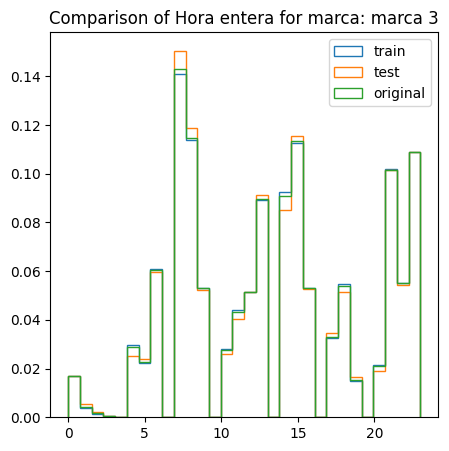

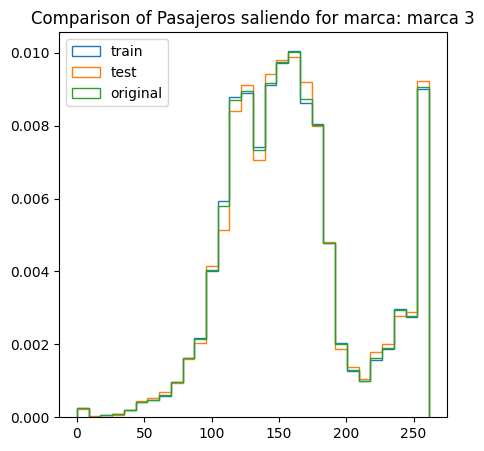

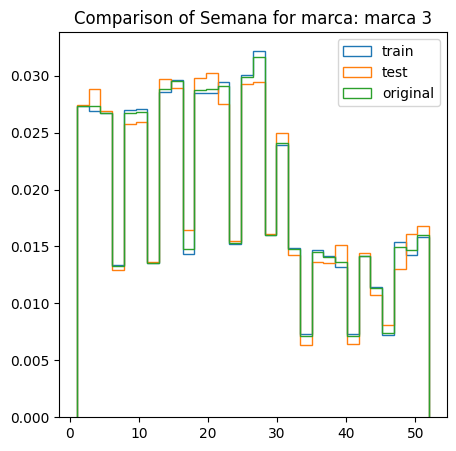

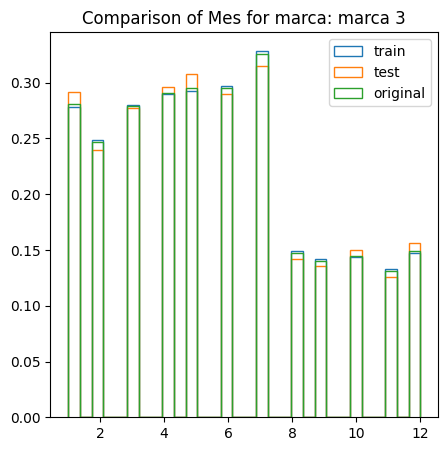

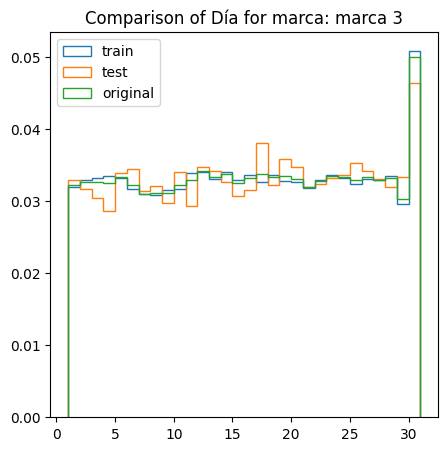

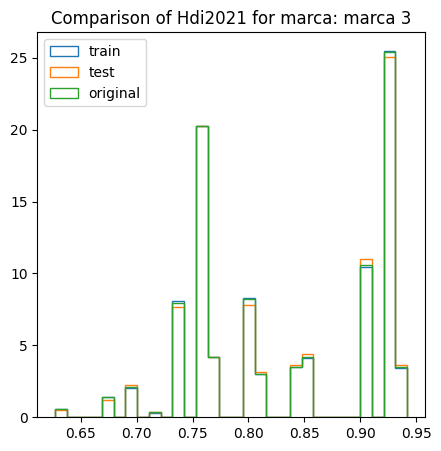

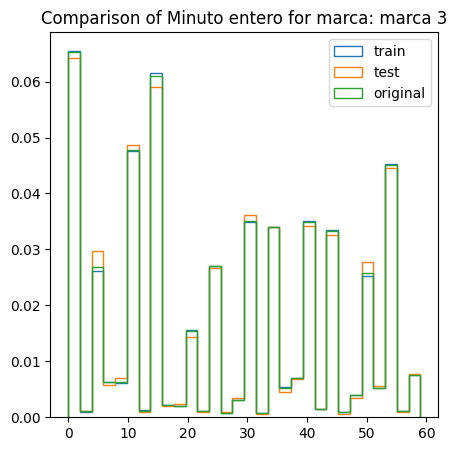

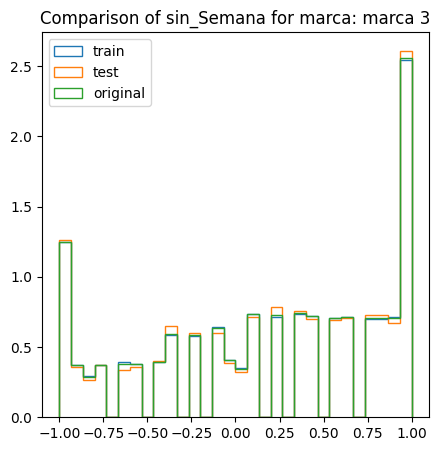

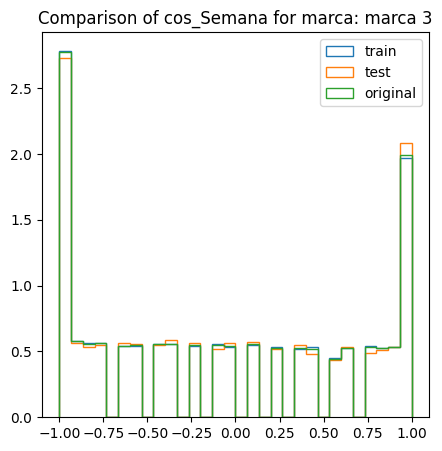

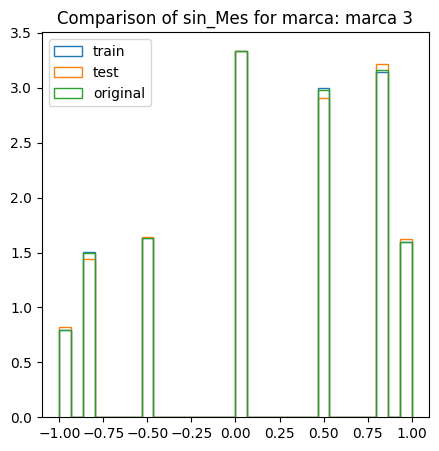

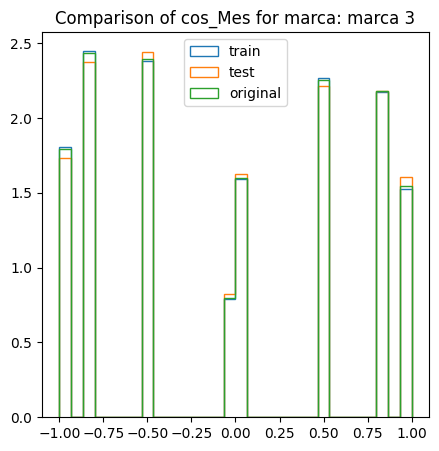

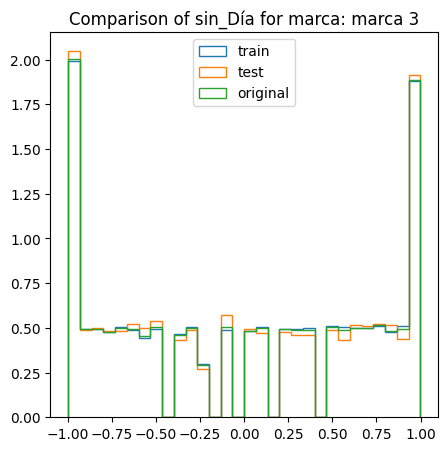

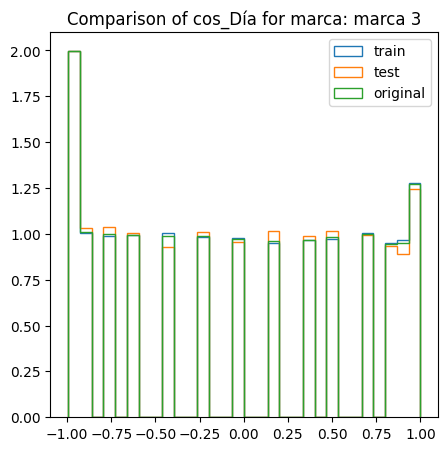

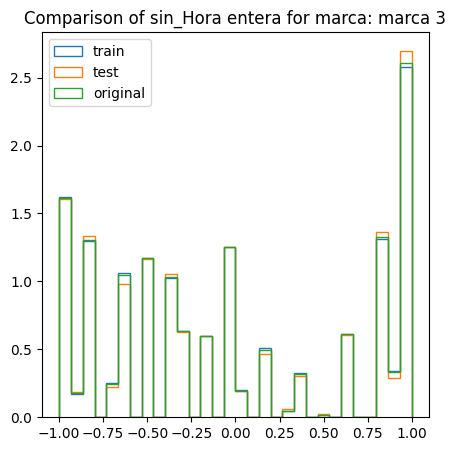

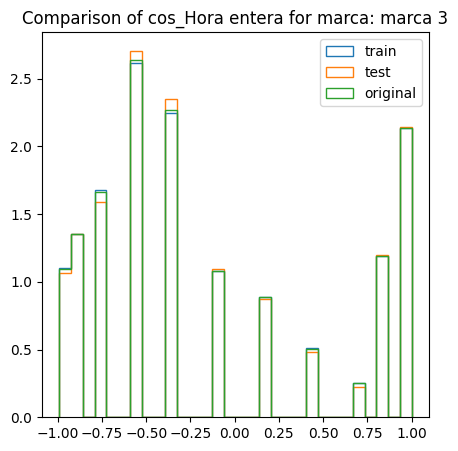

Train statistics


,Hora entera,Pasajeros saliendo,Semana,Mes,Día,Hdi2021,Minuto entero,sin_Semana,cos_Semana,sin_Mes,cos_Mes,sin_Día,cos_Día,sin_Hora entera,cos_Hora entera
count,34271.000000,34271.000000,34271.000000,34271.000000,34271.000000,34271.000000,34271.000000,34271.000000,34271.000000,34271.000000,3.427100e+04,34271.000000,34271.000000,34271.000000,34271.000000
mean,13.392956,159.752079,22.818301,5.661726,15.790785,0.832761,26.155729,0.186269,-0.064995,0.193613,-3.842216e-02,0.000823,-0.020722,-0.029701,-0.149672
std,5.930802,49.387690,13.948119,3.186396,8.796543,0.079934,18.505466,0.659132,0.725708,0.656605,7.279670e-01,0.710005,0.703912,0.704148,0.693484
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.627000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-0.998717,-0.994869,-0.997669,-0.990686
25%,8.000000,125.000000,11.000000,3.000000,8.000000,0.758000,10.000000,-0.354605,-0.822984,-0.500000,-8.660254e-01,-0.724793,-0.758758,-0.631088,-0.775711
50%,13.000000,154.000000,22.000000,5.000000,16.000000,0.809000,25.000000,0.354605,-0.120537,0.500000,6.123234e-17,0.000000,-0.050649,-0.136167,-0.334880
75%,18.000000,182.000000,32.000000,8.000000,23.000000,0.921000,40.000000,0.822984,0.663123,0.866025,5.000000e-01,0.724793,0.688967,0.816970,0.460065
max,23.000000,261.500000,52.000000,12.000000,31.000000,0.942000,59.000000,1.000000,1.000000,1.000000,1.000000e+00,0.998717,1.000000,0.997669,1.000000


Test statistics


,Hora entera,Pasajeros saliendo,Semana,Mes,Día,Hdi2021,Minuto entero,sin_Semana,cos_Semana,sin_Mes,cos_Mes,sin_Día,cos_Día,sin_Hora entera,cos_Hora entera
count,8568.000000,8568.000000,8568.000000,8568.000000,8568.000000,8568.000000,8568.000000,8568.000000,8568.000000,8568.000000,8.568000e+03,8568.000000,8568.000000,8568.000000,8568.000000
mean,13.333683,160.656454,22.776727,5.642157,15.884337,0.833630,26.087068,0.193360,-0.056595,0.198675,-2.726760e-02,-0.009411,-0.029129,-0.020518,-0.149969
std,5.944895,49.417694,14.026513,3.207228,8.745046,0.079625,18.556043,0.658256,0.725410,0.657787,7.260940e-01,0.712777,0.700805,0.707728,0.690162
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.627000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-0.998717,-0.994869,-0.997669,-0.990686
25%,8.000000,126.000000,11.000000,3.000000,8.000000,0.758000,10.000000,-0.354605,-0.822984,-0.500000,-8.660254e-01,-0.724793,-0.758758,-0.631088,-0.775711
50%,13.000000,154.000000,21.000000,5.000000,16.000000,0.838000,25.000000,0.354605,-0.120537,0.500000,6.123234e-17,0.000000,-0.050649,-0.136167,-0.334880
75%,18.000000,182.000000,32.000000,8.000000,23.000000,0.921000,40.000000,0.822984,0.663123,0.866025,8.660254e-01,0.724793,0.688967,0.816970,0.460065
max,23.000000,261.500000,52.000000,12.000000,31.000000,0.942000,59.000000,1.000000,1.000000,1.000000,1.000000e+00,0.998717,1.000000,0.997669,1.000000


Original statistics


,Hora entera,Pasajeros saliendo,Semana,Mes,Día,Hdi2021,Minuto entero,sin_Semana,cos_Semana,sin_Mes,cos_Mes,sin_Día,cos_Día,sin_Hora entera,cos_Hora entera
count,42839.000000,42839.000000,42839.000000,42839.000000,42839.000000,42839.000000,42839.000000,42839.000000,42839.000000,42839.000000,4.283900e+04,42839.000000,42839.000000,42839.000000,42839.000000
mean,13.381101,159.932958,22.809986,5.657812,15.809496,0.832935,26.141997,0.187688,-0.063315,0.194625,-3.619120e-02,-0.001224,-0.022403,-0.027864,-0.149731
std,5.933601,49.394440,13.963679,3.190545,8.786245,0.079872,18.515397,0.658955,0.725648,0.656837,7.275980e-01,0.710564,0.703292,0.704867,0.692813
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.627000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-0.998717,-0.994869,-0.997669,-0.990686
25%,8.000000,125.000000,11.000000,3.000000,8.000000,0.758000,10.000000,-0.354605,-0.822984,-0.500000,-8.660254e-01,-0.724793,-0.758758,-0.631088,-0.775711
50%,13.000000,154.000000,22.000000,5.000000,16.000000,0.809000,25.000000,0.354605,-0.120537,0.500000,6.123234e-17,0.000000,-0.050649,-0.136167,-0.334880
75%,18.000000,182.000000,32.000000,8.000000,23.000000,0.921000,40.000000,0.822984,0.663123,0.866025,5.000000e-01,0.724793,0.688967,0.816970,0.460065
max,23.000000,261.500000,52.000000,12.000000,31.000000,0.942000,59.000000,1.000000,1.000000,1.000000,1.000000e+00,0.998717,1.000000,0.997669,1.000000


KS test statistics


,col,ks_statistic,ks_pvalue
0,Hora entera,0.009270,0.594539
1,Pasajeros saliendo,0.013637,0.154818
2,Semana,0.008769,0.664304
3,Mes,0.009089,0.619674
4,Día,0.010957,0.380237
5,Hdi2021,0.008621,0.684861
6,Minuto entero,0.007985,0.771450
7,sin_Semana,0.008241,0.737190
8,cos_Semana,0.009463,0.568027
9,sin_Mes,0.008164,0.747697


****************************************************************************************************
****************************************************************************************************






****************************************************************************************************
****************************************************************************************************
DISTRIBUTION CHANGES FOR MARCA: marca 5


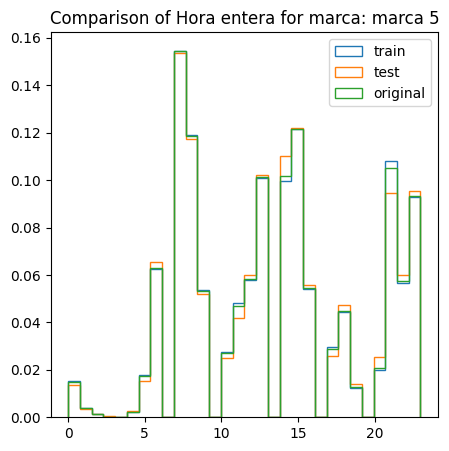

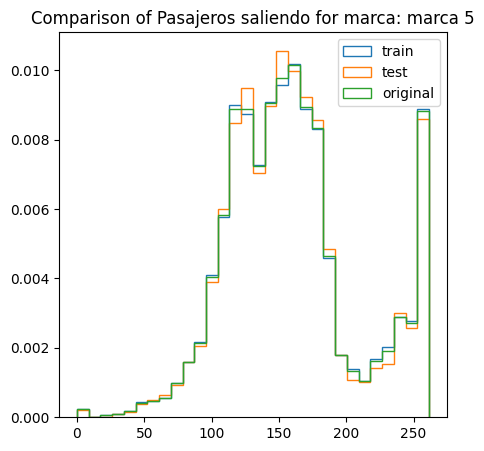

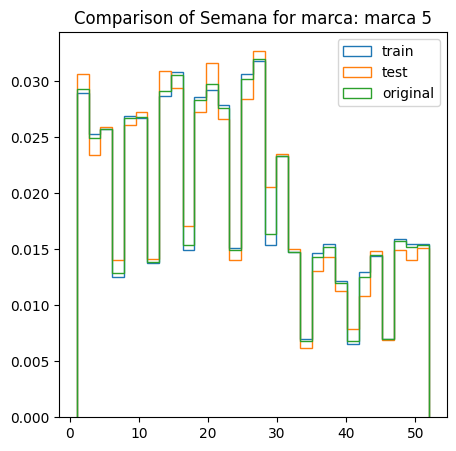

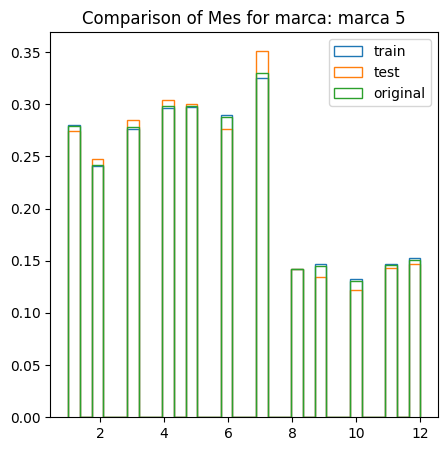

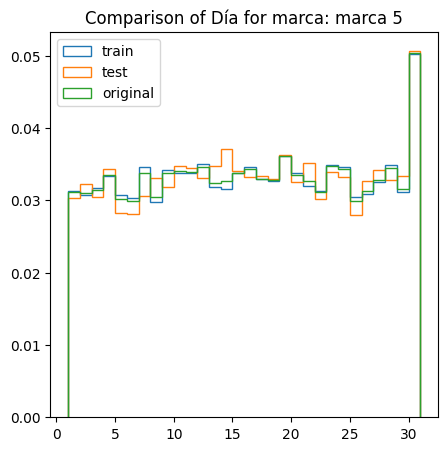

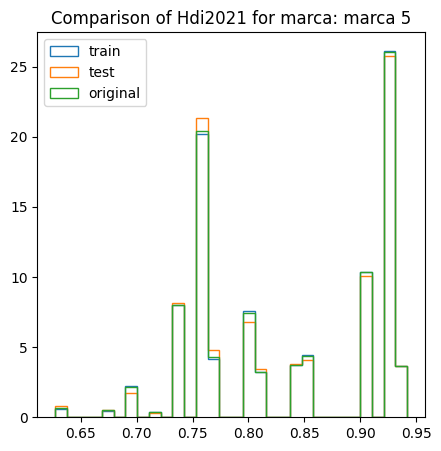

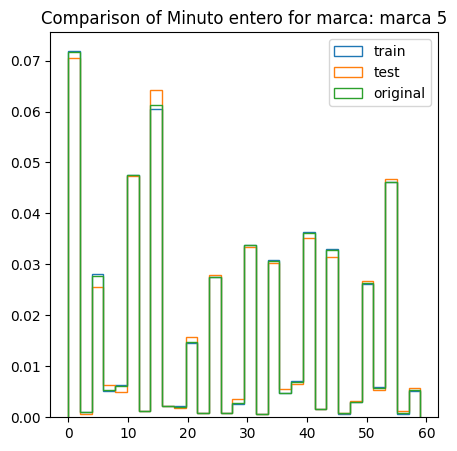

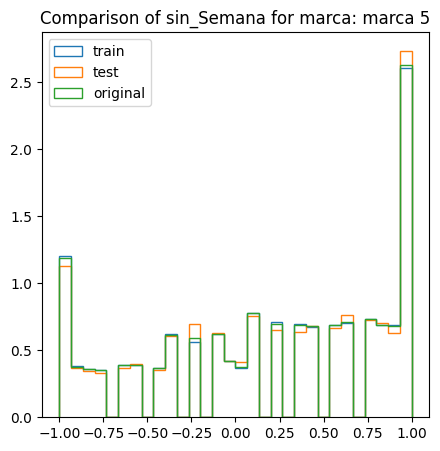

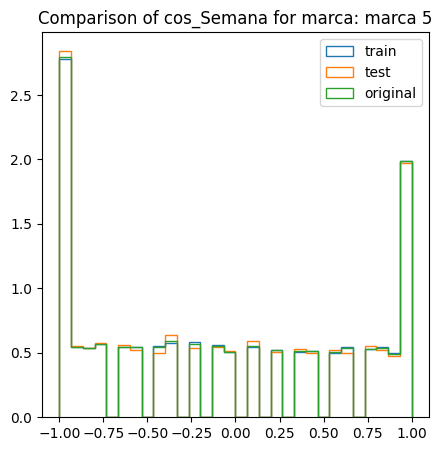

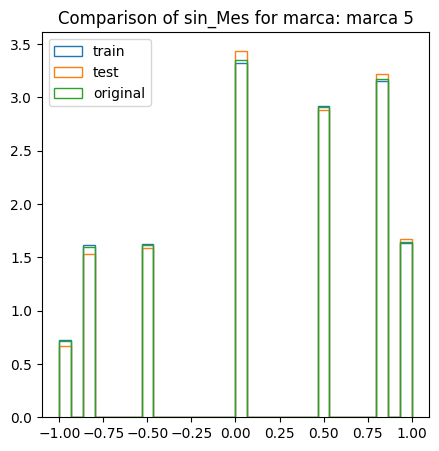

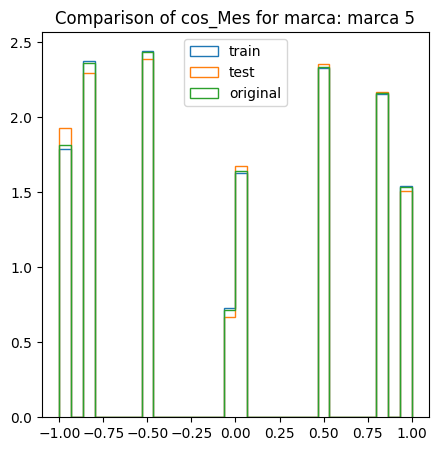

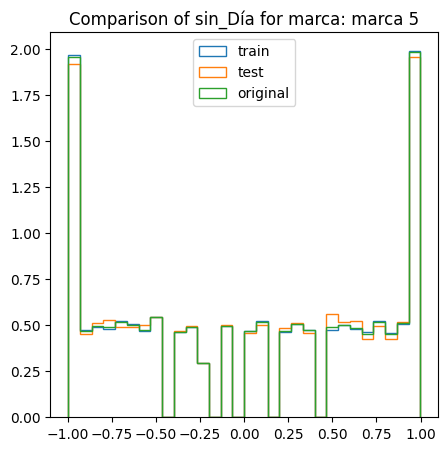

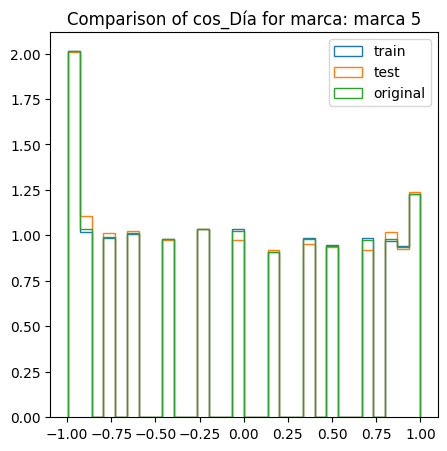

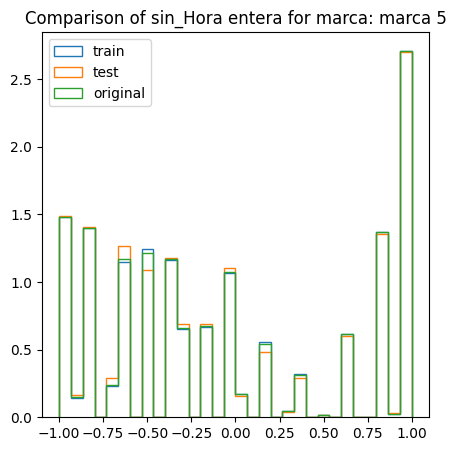

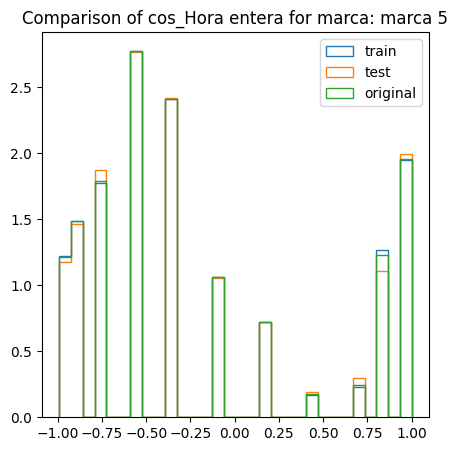

Train statistics


,Hora entera,Pasajeros saliendo,Semana,Mes,Día,Hdi2021,Minuto entero,sin_Semana,cos_Semana,sin_Mes,cos_Mes,sin_Día,cos_Día,sin_Hora entera,cos_Hora entera
count,28309.000000,28309.000000,28309.000000,28309.000000,28309.000000,28309.000000,28309.00000,28309.000000,28309.000000,28309.000000,2.830900e+04,28309.000000,28309.000000,28309.000000,28309.000000
mean,13.398813,159.805080,22.920803,5.687025,15.853015,0.835087,25.64672,0.185794,-0.061386,0.192528,-3.306491e-02,0.001828,-0.028877,-0.040537,-0.202239
std,5.693155,49.263542,14.012979,3.206568,8.747024,0.079055,18.64599,0.660465,0.724936,0.659262,7.261176e-01,0.712112,0.701495,0.697697,0.686082
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.627000,0.00000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-0.998717,-0.994869,-0.997669,-0.990686
25%,8.000000,125.000000,12.000000,3.000000,8.000000,0.758000,10.00000,-0.354605,-0.822984,-0.500000,-8.660254e-01,-0.724793,-0.758758,-0.631088,-0.775711
50%,13.000000,154.000000,22.000000,5.000000,16.000000,0.842000,25.00000,0.239316,-0.120537,0.500000,6.123234e-17,0.000000,-0.050649,-0.136167,-0.334880
75%,18.000000,182.000000,32.000000,8.000000,23.000000,0.921000,40.00000,0.822984,0.663123,0.866025,5.000000e-01,0.724793,0.688967,0.816970,0.203456
max,23.000000,261.500000,52.000000,12.000000,31.000000,0.942000,59.00000,1.000000,1.000000,1.000000,1.000000e+00,0.998717,1.000000,0.997669,1.000000


Test statistics


,Hora entera,Pasajeros saliendo,Semana,Mes,Día,Hdi2021,Minuto entero,sin_Semana,cos_Semana,sin_Mes,cos_Mes,sin_Día,cos_Día,sin_Hora entera,cos_Hora entera
count,7078.000000,7078.000000,7078.000000,7078.000000,7078.000000,7078.000000,7078.000000,7078.000000,7078.000000,7078.000000,7.078000e+03,7078.000000,7078.000000,7078.000000,7078.000000
mean,13.458745,159.310681,22.654281,5.633936,15.913111,0.833312,25.790901,0.197224,-0.068212,0.207557,-3.725538e-02,0.001360,-0.036581,-0.050219,-0.204782
std,5.660868,48.317807,13.881496,3.174153,8.722137,0.079361,18.590979,0.656097,0.725342,0.652067,7.283376e-01,0.708934,0.704425,0.698862,0.683571
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.627000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-0.998717,-0.994869,-0.997669,-0.990686
25%,8.000000,125.250000,11.000000,3.000000,9.000000,0.758000,10.000000,-0.354605,-0.822984,-0.500000,-8.660254e-01,-0.724793,-0.758758,-0.631088,-0.775711
50%,13.000000,154.000000,21.000000,5.000000,16.000000,0.809000,25.000000,0.354605,-0.120537,0.500000,6.123234e-17,0.000000,-0.050649,-0.269797,-0.334880
75%,18.000000,181.000000,31.000000,8.000000,23.000000,0.921000,40.000000,0.822984,0.663123,0.866025,5.000000e-01,0.724793,0.688967,0.816970,0.203456
max,23.000000,261.500000,52.000000,12.000000,31.000000,0.942000,59.000000,1.000000,1.000000,1.000000,1.000000e+00,0.998717,1.000000,0.997669,1.000000


Original statistics


,Hora entera,Pasajeros saliendo,Semana,Mes,Día,Hdi2021,Minuto entero,sin_Semana,cos_Semana,sin_Mes,cos_Mes,sin_Día,cos_Día,sin_Hora entera,cos_Hora entera
count,35387.000000,35387.000000,35387.000000,35387.000000,35387.000000,35387.000000,35387.000000,35387.000000,35387.000000,35387.000000,3.538700e+04,35387.000000,35387.000000,35387.000000,35387.000000
mean,13.410801,159.706192,22.867494,5.676407,15.865035,0.834732,25.675559,0.188080,-0.062751,0.195534,-3.390307e-02,0.001735,-0.030418,-0.042473,-0.202748
std,5.686683,49.075558,13.986990,3.200136,8.741962,0.079119,18.634827,0.659600,0.725012,0.657848,7.265538e-01,0.711467,0.702079,0.697931,0.685572
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.627000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-0.998717,-0.994869,-0.997669,-0.990686
25%,8.000000,125.000000,12.000000,3.000000,8.000000,0.758000,10.000000,-0.354605,-0.822984,-0.500000,-8.660254e-01,-0.724793,-0.758758,-0.631088,-0.775711
50%,13.000000,154.000000,22.000000,5.000000,16.000000,0.838000,25.000000,0.239316,-0.120537,0.500000,6.123234e-17,0.000000,-0.050649,-0.136167,-0.334880
75%,18.000000,182.000000,32.000000,8.000000,23.000000,0.921000,40.000000,0.822984,0.663123,0.866025,5.000000e-01,0.724793,0.688967,0.816970,0.203456
max,23.000000,261.500000,52.000000,12.000000,31.000000,0.942000,59.000000,1.000000,1.000000,1.000000,1.000000e+00,0.998717,1.000000,0.997669,1.000000


KS test statistics


,col,ks_statistic,ks_pvalue
0,Hora entera,0.011097,0.485002
1,Pasajeros saliendo,0.013090,0.283993
2,Semana,0.013695,0.236565
3,Mes,0.011860,0.400143
4,Día,0.008289,0.828265
5,Hdi2021,0.017161,0.070413
6,Minuto entero,0.011233,0.469219
7,sin_Semana,0.011473,0.442110
8,cos_Semana,0.009349,0.701812
9,sin_Mes,0.014061,0.210901


****************************************************************************************************
****************************************************************************************************






****************************************************************************************************
****************************************************************************************************
DISTRIBUTION CHANGES FOR MARCA: marca 6


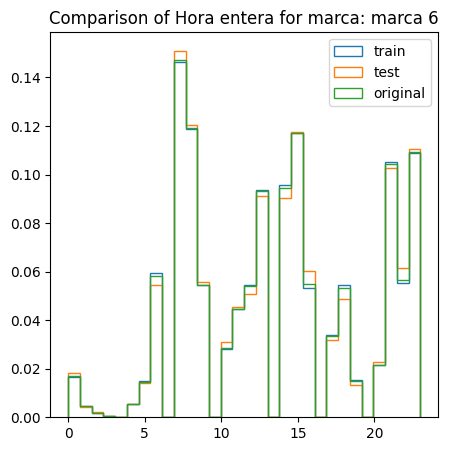

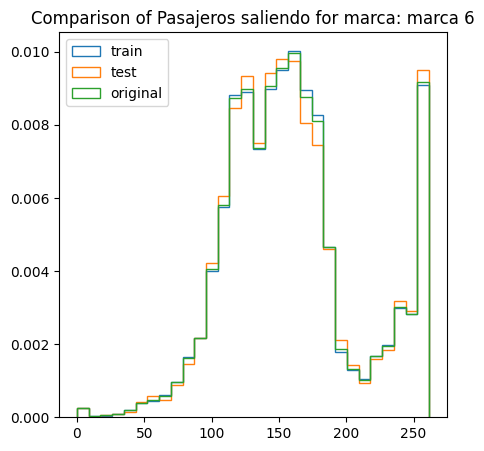

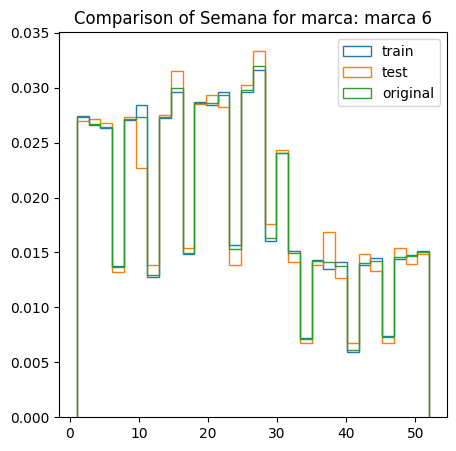

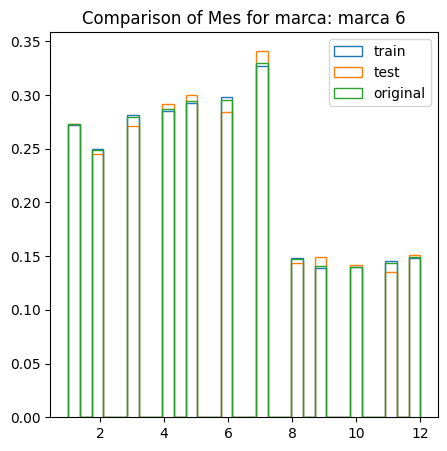

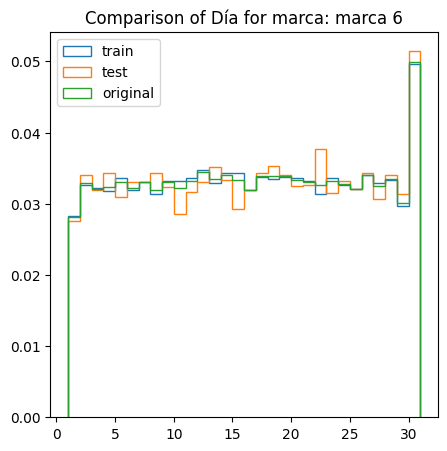

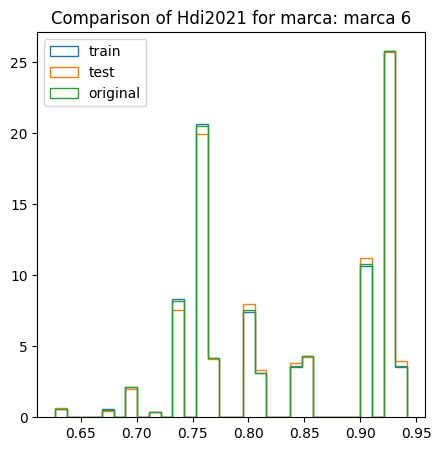

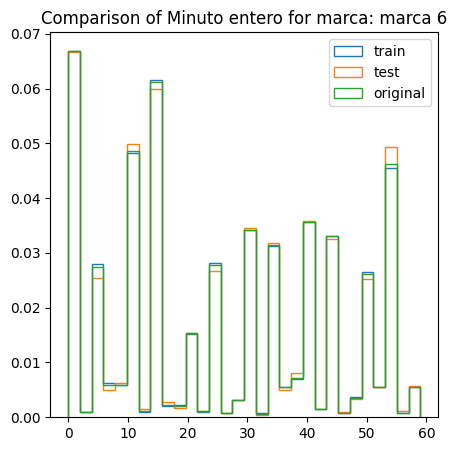

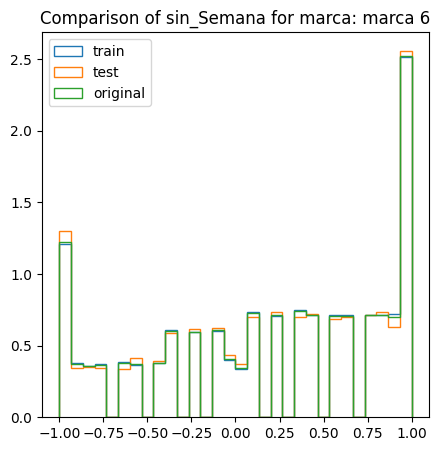

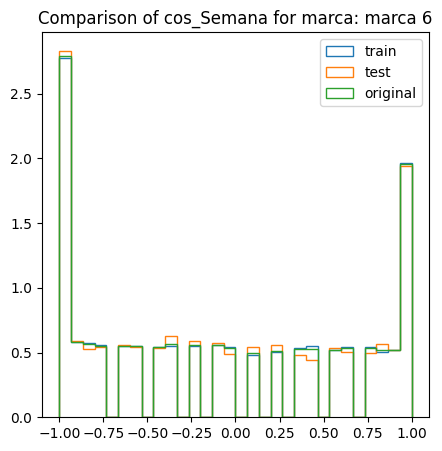

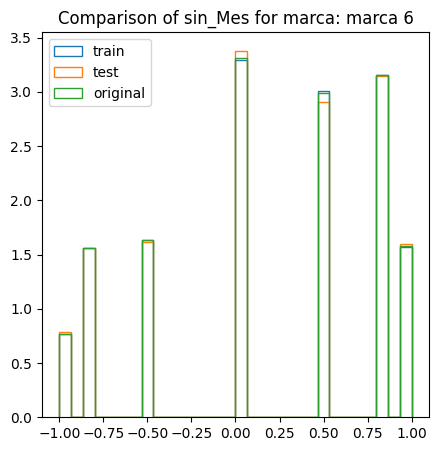

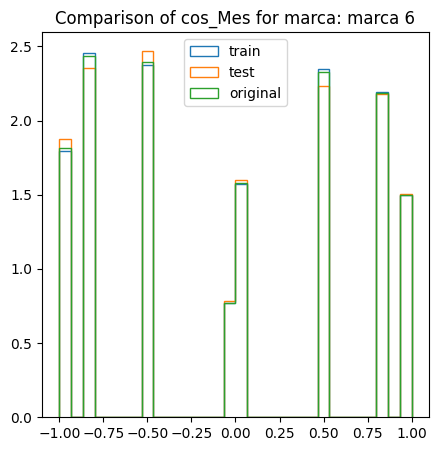

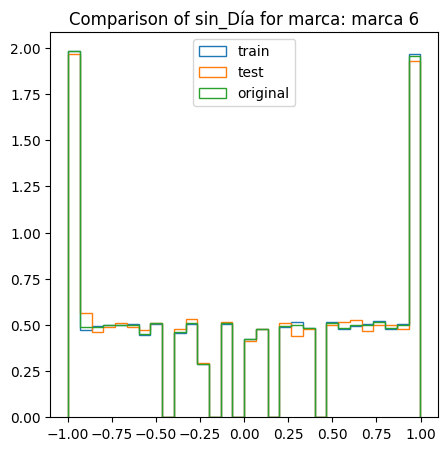

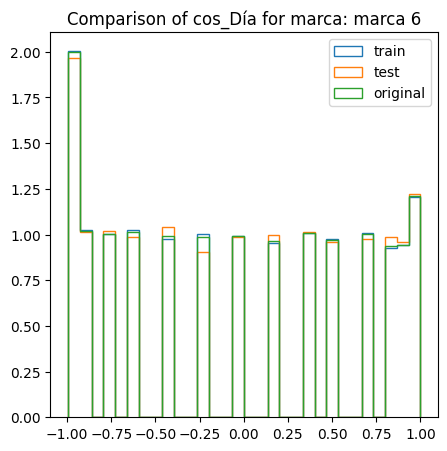

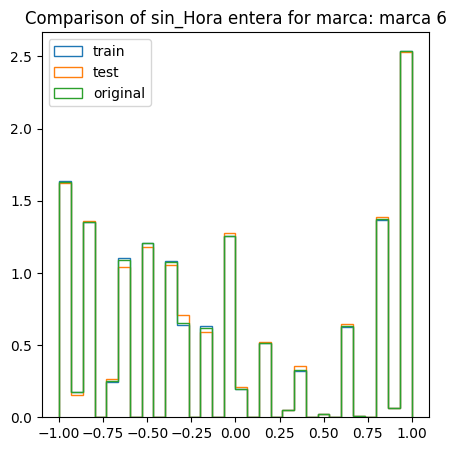

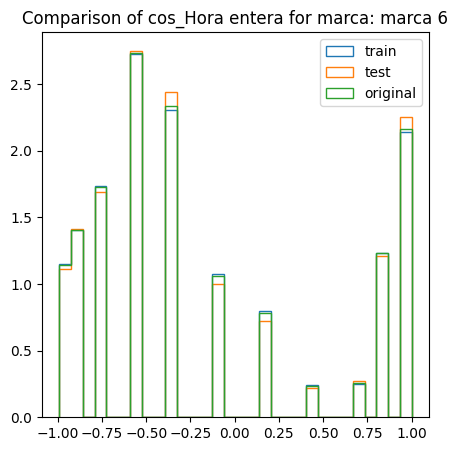

Train statistics


,Hora entera,Pasajeros saliendo,Semana,Mes,Día,Hdi2021,Minuto entero,sin_Semana,cos_Semana,sin_Mes,cos_Mes,sin_Día,cos_Día,sin_Hora entera,cos_Hora entera
count,32852.000000,32852.000000,32852.000000,32852.000000,32852.000000,32852.000000,32852.000000,32852.000000,32852.000000,32852.000000,3.285200e+04,32852.000000,32852.000000,32852.000000,32852.000000
mean,13.588731,160.156657,22.846554,5.687782,15.817028,0.834210,25.876842,0.185478,-0.063390,0.191531,-3.602711e-02,0.005825,-0.029973,-0.053362,-0.170536
std,5.797745,49.441759,13.958879,3.198327,8.726194,0.079239,18.496377,0.659586,0.725641,0.657758,7.275996e-01,0.713288,0.700228,0.696439,0.695034
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.627000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-0.998717,-0.994869,-0.997669,-0.990686
25%,8.000000,125.000000,11.000000,3.000000,8.000000,0.758000,10.000000,-0.354605,-0.822984,-0.500000,-8.660254e-01,-0.724793,-0.758758,-0.631088,-0.775711
50%,14.000000,154.000000,22.000000,5.000000,16.000000,0.838000,25.000000,0.354605,-0.120537,0.500000,6.123234e-17,0.000000,-0.050649,-0.136167,-0.334880
75%,18.000000,182.000000,32.000000,8.000000,23.000000,0.921000,40.000000,0.822984,0.663123,0.866025,5.000000e-01,0.724793,0.688967,0.816970,0.460065
max,23.000000,261.500000,52.000000,12.000000,31.000000,0.942000,59.000000,1.000000,1.000000,1.000000,1.000000e+00,0.998717,1.000000,0.997669,1.000000


Test statistics


,Hora entera,Pasajeros saliendo,Semana,Mes,Día,Hdi2021,Minuto entero,sin_Semana,cos_Semana,sin_Mes,cos_Mes,sin_Día,cos_Día,sin_Hora entera,cos_Hora entera
count,8213.000000,8213.000000,8213.000000,8213.000000,8213.000000,8213.000000,8213.000000,8213.000000,8213.000000,8213.000000,8.213000e+03,8213.000000,8213.000000,8213.000000,8213.000000
mean,13.591258,160.329478,22.927919,5.699379,15.887252,0.836652,26.194813,0.179556,-0.071489,0.189027,-4.310294e-02,-0.003813,-0.022269,-0.047012,-0.165199
std,5.838996,49.886884,13.917759,3.189669,8.775739,0.078602,18.587330,0.661371,0.724814,0.658767,7.270177e-01,0.712546,0.701349,0.694609,0.698667
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.627000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-0.998717,-0.994869,-0.997669,-0.990686
25%,8.000000,125.000000,12.000000,3.000000,8.000000,0.758000,10.000000,-0.354605,-0.822984,-0.500000,-8.660254e-01,-0.724793,-0.758758,-0.631088,-0.775711
50%,14.000000,153.000000,22.000000,5.000000,16.000000,0.842000,25.000000,0.239316,-0.120537,0.500000,6.123234e-17,0.000000,-0.050649,-0.136167,-0.334880
75%,18.000000,183.000000,32.000000,8.000000,23.000000,0.921000,40.000000,0.822984,0.663123,0.866025,5.000000e-01,0.724793,0.688967,0.816970,0.460065
max,23.000000,261.500000,52.000000,12.000000,31.000000,0.942000,59.000000,1.000000,1.000000,1.000000,1.000000e+00,0.998717,1.000000,0.997669,1.000000


Original statistics


,Hora entera,Pasajeros saliendo,Semana,Mes,Día,Hdi2021,Minuto entero,sin_Semana,cos_Semana,sin_Mes,cos_Mes,sin_Día,cos_Día,sin_Hora entera,cos_Hora entera
count,41065.000000,41065.000000,41065.000000,41065.000000,41065.000000,41065.000000,41065.000000,41065.000000,41065.000000,41065.000000,4.106500e+04,41065.000000,41065.000000,41065.000000,41065.000000
mean,13.589237,160.191221,22.862827,5.690101,15.831073,0.834698,25.940436,0.184293,-0.065010,0.191030,-3.744228e-02,0.003897,-0.028432,-0.052092,-0.169469
std,5.805947,49.530543,13.950534,3.196562,8.736063,0.079117,18.514814,0.659940,0.725474,0.657953,7.274799e-01,0.713141,0.700450,0.696070,0.695757
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.627000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-0.998717,-0.994869,-0.997669,-0.990686
25%,8.000000,125.000000,11.000000,3.000000,8.000000,0.758000,10.000000,-0.354605,-0.822984,-0.500000,-8.660254e-01,-0.724793,-0.758758,-0.631088,-0.775711
50%,14.000000,154.000000,22.000000,5.000000,16.000000,0.838000,25.000000,0.354605,-0.120537,0.500000,6.123234e-17,0.000000,-0.050649,-0.136167,-0.334880
75%,18.000000,182.000000,32.000000,8.000000,23.000000,0.921000,40.000000,0.822984,0.663123,0.866025,5.000000e-01,0.724793,0.688967,0.816970,0.460065
max,23.000000,261.500000,52.000000,12.000000,31.000000,0.942000,59.000000,1.000000,1.000000,1.000000,1.000000e+00,0.998717,1.000000,0.997669,1.000000


KS test statistics


,col,ks_statistic,ks_pvalue
0,Hora entera,0.006057,0.968230
1,Pasajeros saliendo,0.011050,0.395945
2,Semana,0.009467,0.594673
3,Mes,0.005266,0.992858
4,Día,0.008340,0.747345
5,Hdi2021,0.019725,0.011883
6,Minuto entero,0.008949,0.665222
7,sin_Semana,0.008158,0.771168
8,cos_Semana,0.012693,0.238322
9,sin_Mes,0.005570,0.986265


****************************************************************************************************
****************************************************************************************************






****************************************************************************************************
****************************************************************************************************
DISTRIBUTION CHANGES FOR MARCA: marca 7


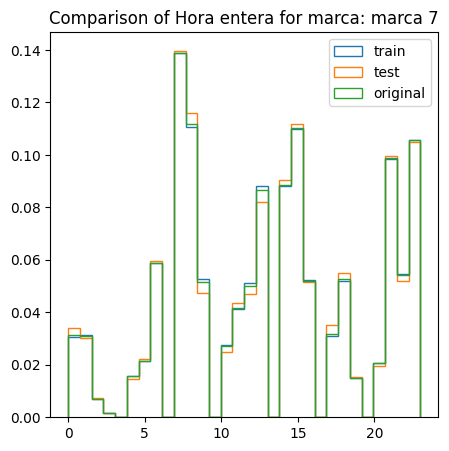

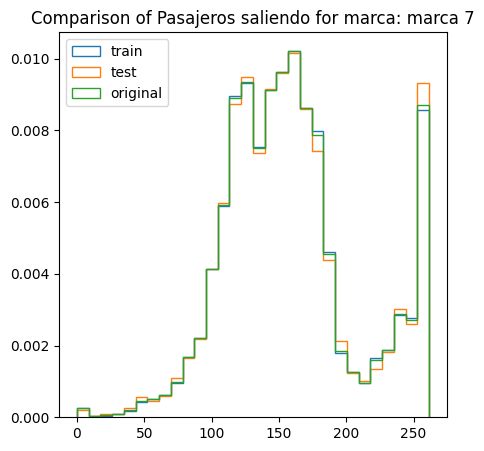

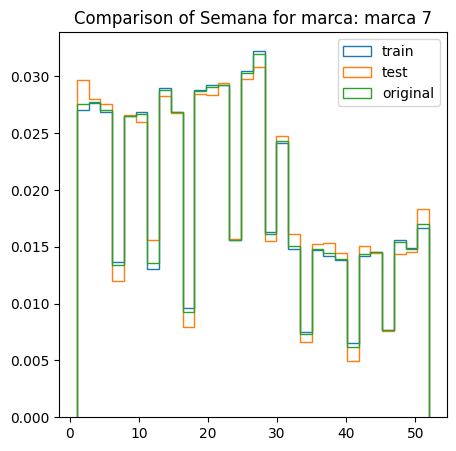

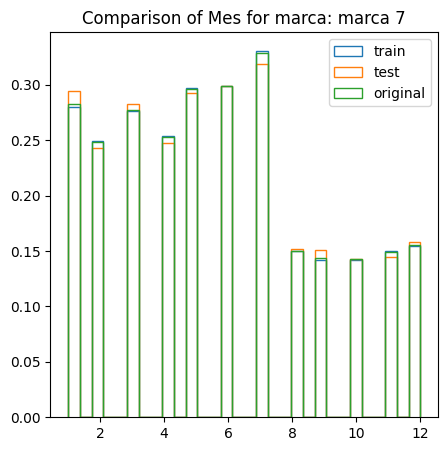

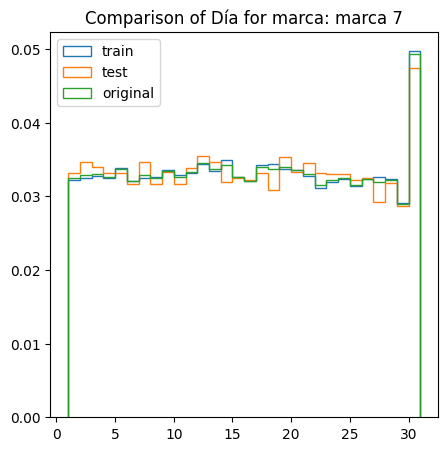

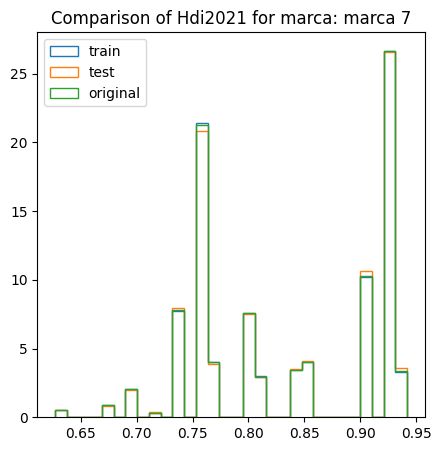

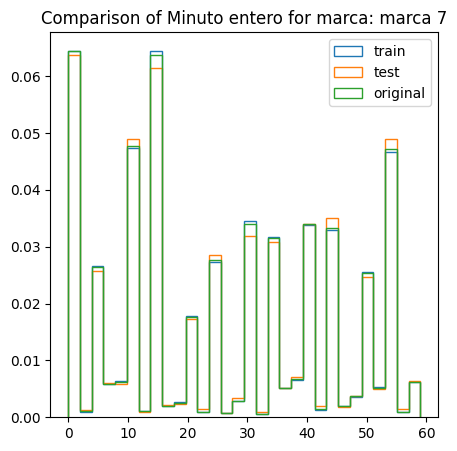

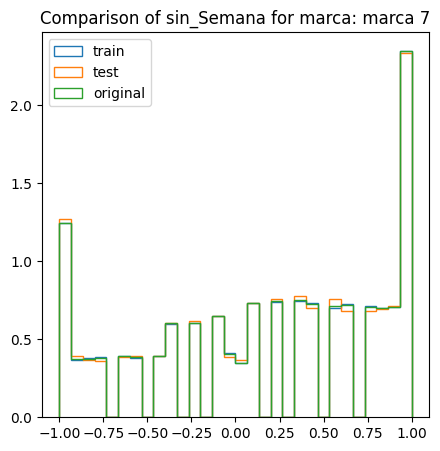

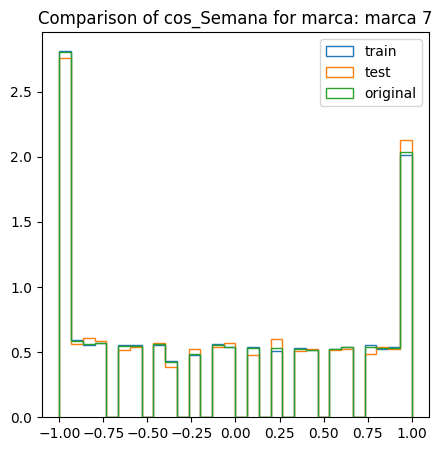

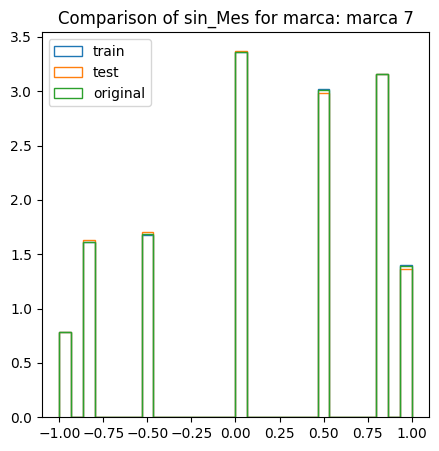

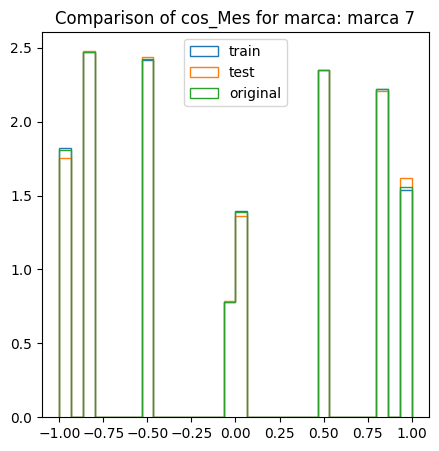

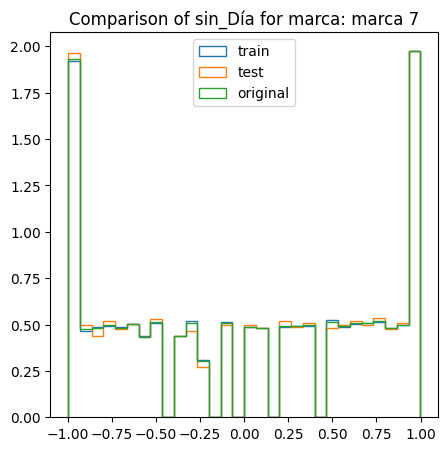

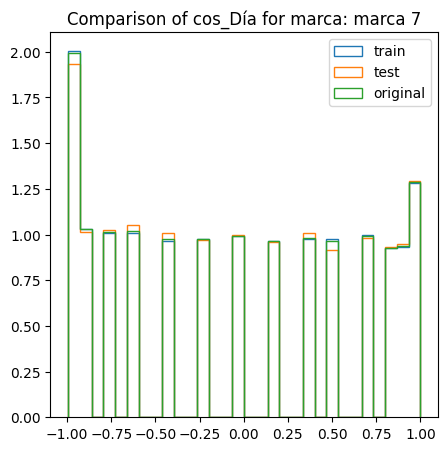

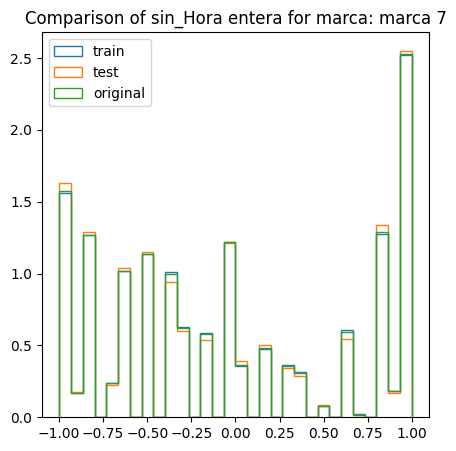

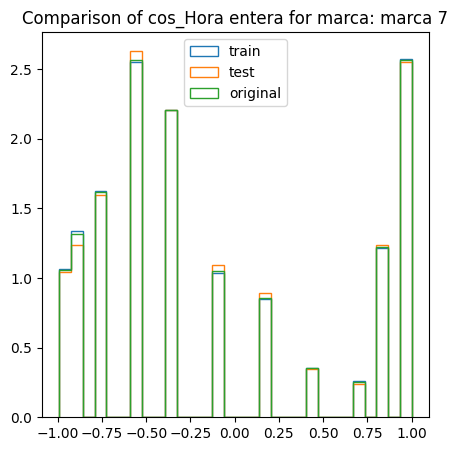

Train statistics


,Hora entera,Pasajeros saliendo,Semana,Mes,Día,Hdi2021,Minuto entero,sin_Semana,cos_Semana,sin_Mes,cos_Mes,sin_Día,cos_Día,sin_Hora entera,cos_Hora entera
count,34900.000000,34900.000000,34900.000000,34900.000000,34900.000000,34900.000000,34900.000000,34900.000000,34900.000000,34900.000000,3.490000e+04,34900.000000,34900.000000,34900.000000,34900.000000
mean,13.011375,158.849484,23.106476,5.733438,15.678252,0.834122,26.005616,0.169230,-0.057581,0.175133,-3.539526e-02,0.012902,-0.026078,-0.026713,-0.115007
std,6.251092,49.041410,14.118516,3.227690,8.757688,0.079589,18.459221,0.658608,0.730965,0.656715,7.326858e-01,0.710162,0.703457,0.690939,0.713226
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.627000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-0.998717,-0.994869,-0.997669,-0.990686
25%,8.000000,125.000000,11.000000,3.000000,8.000000,0.758000,10.000000,-0.354605,-0.822984,-0.500000,-8.660254e-01,-0.724793,-0.758758,-0.631088,-0.775711
50%,13.000000,153.000000,22.000000,6.000000,16.000000,0.838000,25.000000,0.239316,-0.120537,0.500000,6.123234e-17,0.000000,-0.050649,-0.136167,-0.334880
75%,18.000000,181.000000,33.000000,8.000000,23.000000,0.921000,40.000000,0.822984,0.663123,0.866025,8.660254e-01,0.724793,0.688967,0.816970,0.854419
max,23.000000,261.500000,52.000000,12.000000,31.000000,0.942000,59.000000,1.000000,1.000000,1.000000,1.000000e+00,0.998717,1.000000,0.997669,1.000000


Test statistics


,Hora entera,Pasajeros saliendo,Semana,Mes,Día,Hdi2021,Minuto entero,sin_Semana,cos_Semana,sin_Mes,cos_Mes,sin_Día,cos_Día,sin_Hora entera,cos_Hora entera
count,8725.000000,8725.000000,8725.000000,8725.000000,8725.000000,8725.000000,8725.000000,8725.000000,8725.000000,8725.000000,8.725000e+03,8725.000000,8725.000000,8725.000000,8725.000000
mean,12.989685,159.094670,23.061891,5.721948,15.570086,0.835305,26.322865,0.165278,-0.048712,0.169570,-2.748791e-02,0.012430,-0.023833,-0.029847,-0.110225
std,6.267983,49.822557,14.219405,3.247922,8.759186,0.079480,18.553742,0.658956,0.732255,0.657342,7.338282e-01,0.712222,0.701521,0.696065,0.708919
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.627000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-0.998717,-0.994869,-0.997669,-0.990686
25%,8.000000,125.000000,11.000000,3.000000,8.000000,0.758000,10.000000,-0.354605,-0.822984,-0.500000,-8.660254e-01,-0.724793,-0.758758,-0.631088,-0.775711
50%,13.000000,153.000000,22.000000,6.000000,16.000000,0.842000,25.000000,0.239316,-0.120537,0.500000,6.123234e-17,0.000000,-0.050649,-0.136167,-0.334880
75%,18.000000,181.000000,33.000000,8.000000,23.000000,0.921000,43.000000,0.748511,0.663123,0.866025,8.660254e-01,0.724793,0.688967,0.816970,0.854419
max,23.000000,261.500000,52.000000,12.000000,31.000000,0.942000,59.000000,1.000000,1.000000,1.000000,1.000000e+00,0.998717,1.000000,0.997669,1.000000


Original statistics


,Hora entera,Pasajeros saliendo,Semana,Mes,Día,Hdi2021,Minuto entero,sin_Semana,cos_Semana,sin_Mes,cos_Mes,sin_Día,cos_Día,sin_Hora entera,cos_Hora entera
count,43625.000000,43625.000000,43625.000000,43625.000000,43625.000000,43625.000000,43625.000000,43625.000000,43625.000000,43625.000000,4.362500e+04,43625.000000,43625.000000,43625.000000,43625.000000
mean,13.007037,158.898521,23.097559,5.731140,15.656619,0.834359,26.069066,0.168440,-0.055807,0.174021,-3.381379e-02,0.012808,-0.025629,-0.027340,-0.114051
std,6.254408,49.198155,14.138599,3.231712,8.757994,0.079568,18.478387,0.658672,0.731223,0.656837,7.329128e-01,0.710566,0.703063,0.691960,0.712361
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.627000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-0.998717,-0.994869,-0.997669,-0.990686
25%,8.000000,125.000000,11.000000,3.000000,8.000000,0.758000,10.000000,-0.354605,-0.822984,-0.500000,-8.660254e-01,-0.724793,-0.758758,-0.631088,-0.775711
50%,13.000000,153.000000,22.000000,6.000000,16.000000,0.838000,25.000000,0.239316,-0.120537,0.500000,6.123234e-17,0.000000,-0.050649,-0.136167,-0.334880
75%,18.000000,181.000000,33.000000,8.000000,23.000000,0.921000,40.000000,0.748511,0.663123,0.866025,8.660254e-01,0.724793,0.688967,0.816970,0.854419
max,23.000000,261.500000,52.000000,12.000000,31.000000,0.942000,59.000000,1.000000,1.000000,1.000000,1.000000e+00,0.998717,1.000000,0.997669,1.000000


KS test statistics


,col,ks_statistic,ks_pvalue
0,Hora entera,0.006562,0.922639
1,Pasajeros saliendo,0.007421,0.833889
2,Semana,0.006418,0.934164
3,Mes,0.005272,0.989619
4,Día,0.006590,0.920212
5,Hdi2021,0.007507,0.823458
6,Minuto entero,0.010516,0.420149
7,sin_Semana,0.006189,0.950434
8,cos_Semana,0.008395,0.705585
9,sin_Mes,0.008854,0.641165


****************************************************************************************************
****************************************************************************************************






****************************************************************************************************
****************************************************************************************************
DISTRIBUTION CHANGES FOR MARCA: marca 9


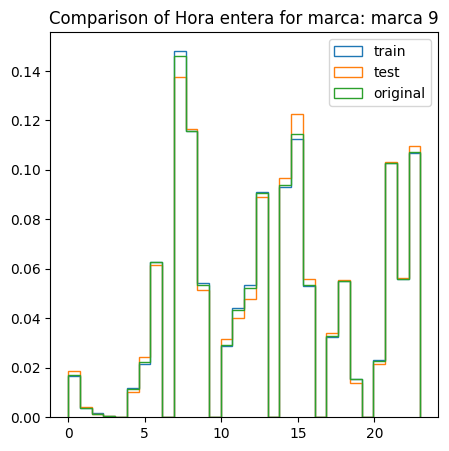

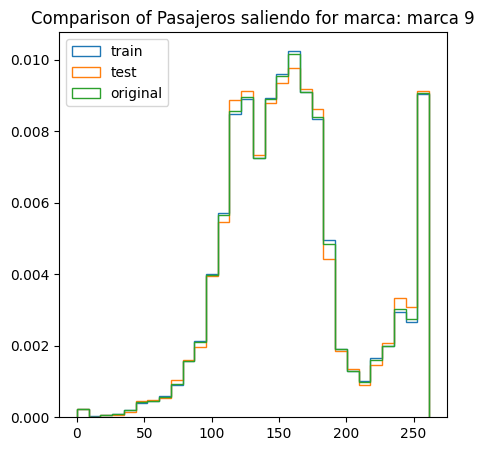

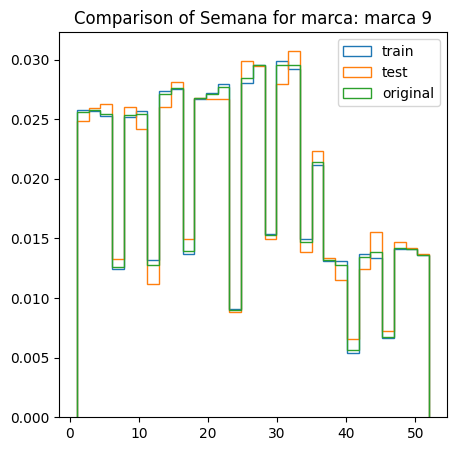

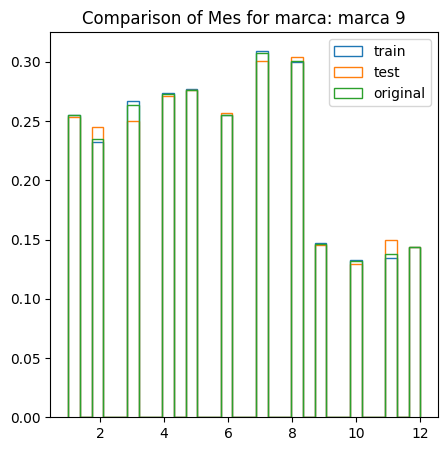

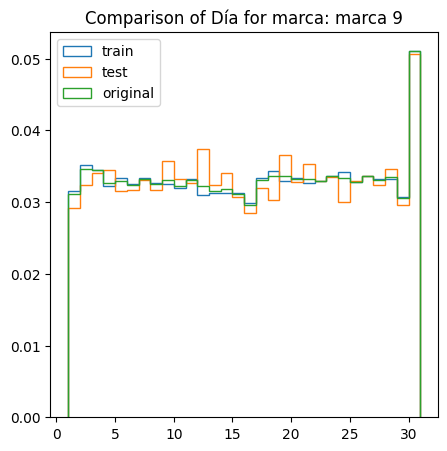

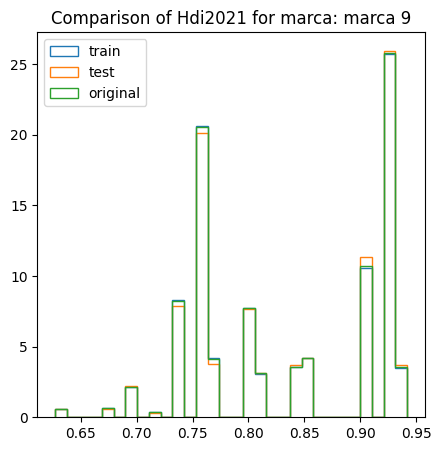

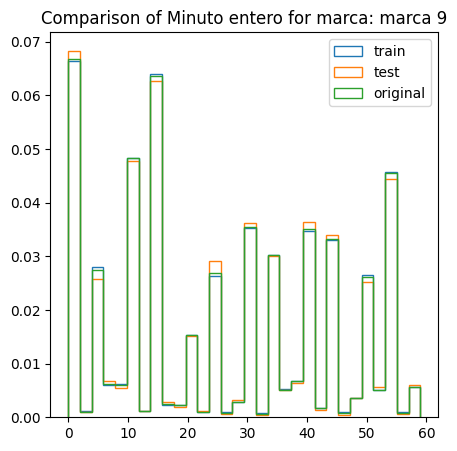

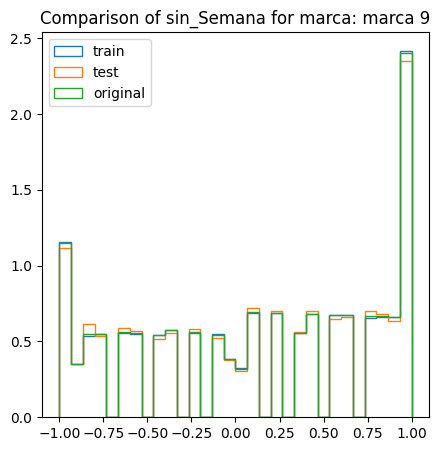

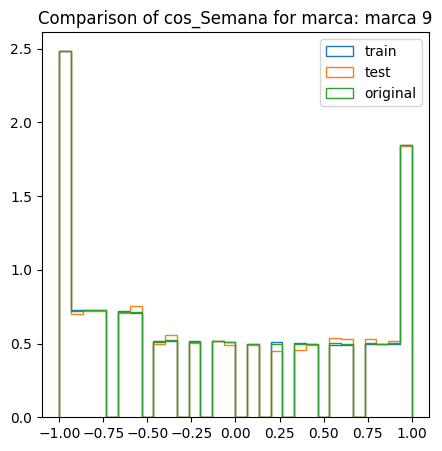

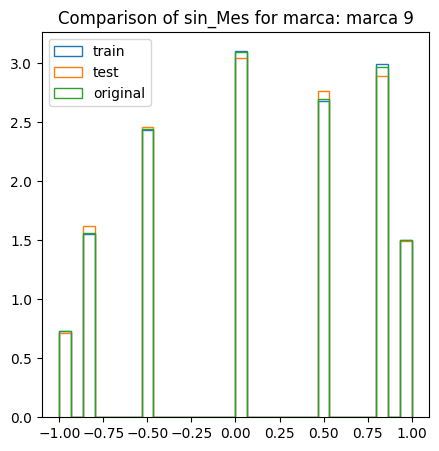

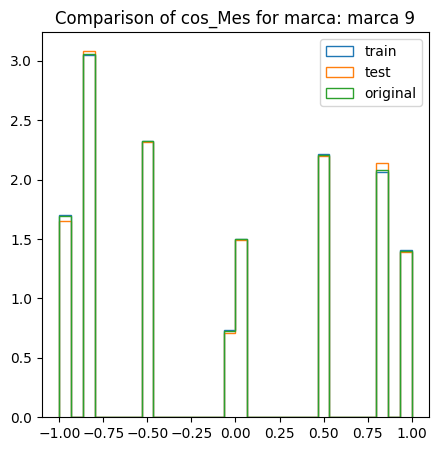

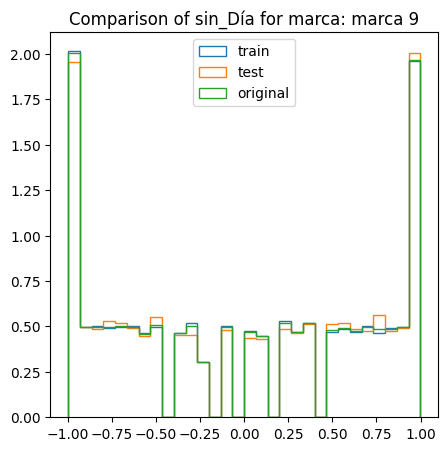

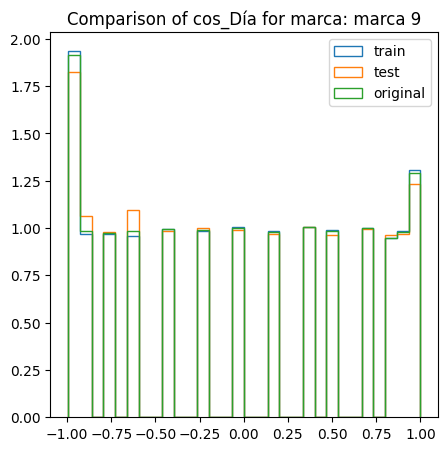

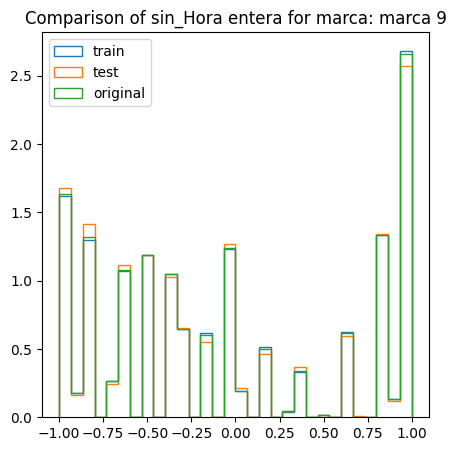

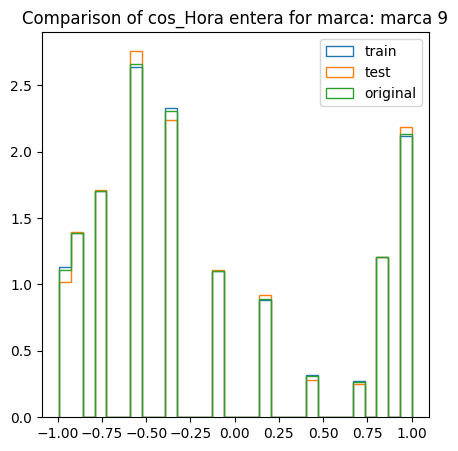

Train statistics


,Hora entera,Pasajeros saliendo,Semana,Mes,Día,Hdi2021,Minuto entero,sin_Semana,cos_Semana,sin_Mes,cos_Mes,sin_Día,cos_Día,sin_Hora entera,cos_Hora entera
count,35648.000000,35648.000000,35648.000000,35648.000000,35648.000000,35648.000000,35648.000000,35648.000000,35648.000000,3.564800e+04,3.564800e+04,35648.000000,35648.000000,35648.000000,35648.000000
mean,13.476577,160.347285,23.462438,5.848014,15.783831,0.833749,25.799961,0.129862,-0.098655,1.428580e-01,-8.044780e-02,-0.003524,-0.007145,-0.036315,-0.162537
std,5.851724,49.184303,13.789231,3.164692,8.859394,0.079322,18.502002,0.674894,0.719687,6.640129e-01,7.295436e-01,0.713020,0.701118,0.702532,0.691910
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.627000,0.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,-0.998717,-0.994869,-0.997669,-0.990686
25%,8.000000,126.000000,12.000000,3.000000,8.000000,0.758000,10.000000,-0.464723,-0.822984,-5.000000e-01,-8.660254e-01,-0.724793,-0.758758,-0.631088,-0.775711
50%,13.000000,155.000000,23.000000,6.000000,16.000000,0.809000,25.000000,0.239316,-0.239316,1.224647e-16,-1.836970e-16,0.000000,-0.050649,-0.136167,-0.334880
75%,18.000000,182.000000,33.000000,8.000000,23.000000,0.921000,40.000000,0.748511,0.663123,8.660254e-01,5.000000e-01,0.724793,0.688967,0.816970,0.460065
max,23.000000,261.500000,52.000000,12.000000,31.000000,0.942000,59.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,0.998717,1.000000,0.997669,1.000000


Test statistics


,Hora entera,Pasajeros saliendo,Semana,Mes,Día,Hdi2021,Minuto entero,sin_Semana,cos_Semana,sin_Mes,cos_Mes,sin_Día,cos_Día,sin_Hora entera,cos_Hora entera
count,8913.000000,8913.000000,8913.000000,8913.000000,8913.000000,8913.000000,8913.000000,8913.000000,8913.000000,8.913000e+03,8.913000e+03,8913.000000,8913.000000,8913.000000,8913.000000
mean,13.555256,160.761304,23.583081,5.874790,15.781218,0.835957,25.767418,0.123794,-0.094321,1.352911e-01,-7.609181e-02,0.007077,-0.018062,-0.053353,-0.156081
std,5.864599,49.752362,13.856968,3.184347,8.786627,0.079189,18.439645,0.674539,0.721724,6.647469e-01,7.308403e-01,0.715891,0.698023,0.701840,0.693053
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.627000,0.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,-0.998717,-0.994869,-0.997669,-0.990686
25%,8.000000,126.000000,12.000000,3.000000,8.000000,0.758000,10.000000,-0.568065,-0.822984,-5.000000e-01,-8.660254e-01,-0.724793,-0.758758,-0.631088,-0.775711
50%,14.000000,155.000000,23.000000,6.000000,16.000000,0.842000,25.000000,0.239316,-0.239316,1.224647e-16,-1.836970e-16,0.000000,-0.050649,-0.136167,-0.334880
75%,18.000000,182.000000,33.000000,8.000000,23.000000,0.921000,40.000000,0.748511,0.663123,8.660254e-01,5.000000e-01,0.724793,0.688967,0.816970,0.460065
max,23.000000,261.500000,52.000000,12.000000,31.000000,0.942000,59.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,0.998717,1.000000,0.997669,1.000000


Original statistics


,Hora entera,Pasajeros saliendo,Semana,Mes,Día,Hdi2021,Minuto entero,sin_Semana,cos_Semana,sin_Mes,cos_Mes,sin_Día,cos_Día,sin_Hora entera,cos_Hora entera
count,44561.000000,44561.000000,44561.000000,44561.000000,44561.000000,44561.000000,44561.000000,44561.000000,44561.000000,4.456100e+04,4.456100e+04,44561.000000,44561.000000,44561.000000,44561.000000
mean,13.492314,160.430096,23.486569,5.853370,15.783308,0.834191,25.793452,0.128648,-0.097788,1.413445e-01,-7.957653e-02,-0.001404,-0.009328,-0.039723,-0.161246
std,5.854320,49.298166,13.802735,3.168615,8.844789,0.079299,18.489344,0.674820,0.720089,6.641592e-01,7.297970e-01,0.713600,0.700506,0.702419,0.692136
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.627000,0.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,-0.998717,-0.994869,-0.997669,-0.990686
25%,8.000000,126.000000,12.000000,3.000000,8.000000,0.758000,10.000000,-0.464723,-0.822984,-5.000000e-01,-8.660254e-01,-0.724793,-0.758758,-0.631088,-0.775711
50%,14.000000,155.000000,23.000000,6.000000,16.000000,0.838000,25.000000,0.239316,-0.239316,1.224647e-16,-1.836970e-16,0.000000,-0.050649,-0.136167,-0.334880
75%,18.000000,182.000000,33.000000,8.000000,23.000000,0.921000,40.000000,0.748511,0.663123,8.660254e-01,5.000000e-01,0.724793,0.688967,0.816970,0.460065
max,23.000000,261.500000,52.000000,12.000000,31.000000,0.942000,59.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,0.998717,1.000000,0.997669,1.000000


KS test statistics


,col,ks_statistic,ks_pvalue
0,Hora entera,0.014810,0.086762
1,Pasajeros saliendo,0.008961,0.612689
2,Semana,0.006110,0.951357
3,Mes,0.005546,0.979851
4,Día,0.007379,0.829548
5,Hdi2021,0.014947,0.081870
6,Minuto entero,0.005159,0.990889
7,sin_Semana,0.006446,0.926509
8,cos_Semana,0.009252,0.571723
9,sin_Mes,0.007242,0.845938


****************************************************************************************************
****************************************************************************************************






****************************************************************************************************
****************************************************************************************************
DISTRIBUTION CHANGES FOR MARCA: marca 10


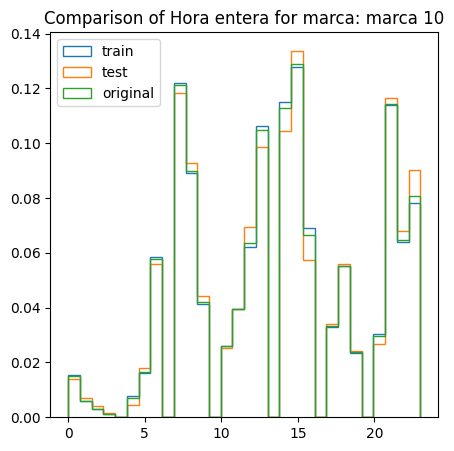

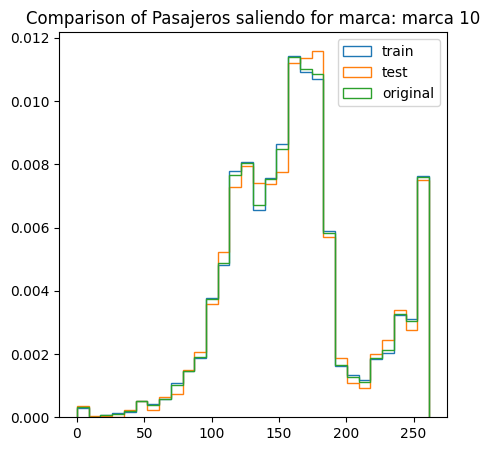

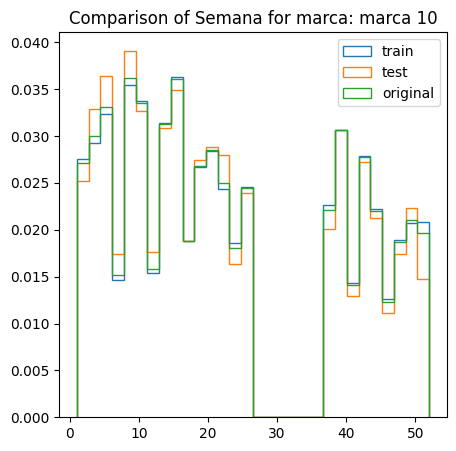

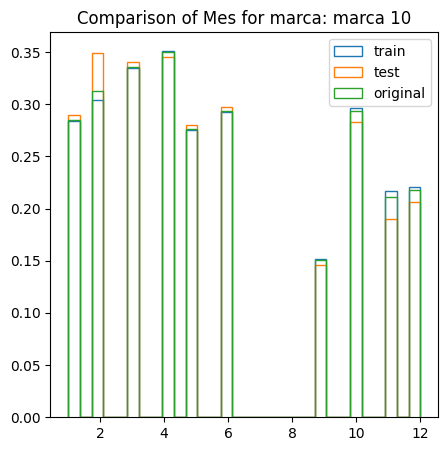

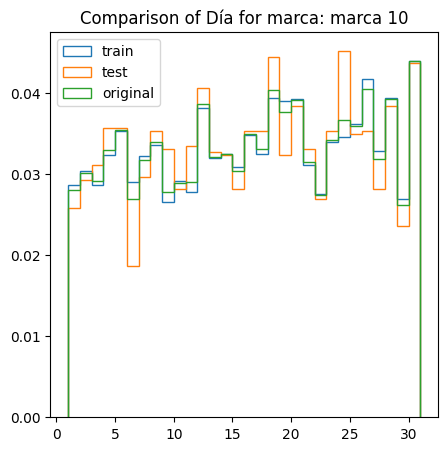

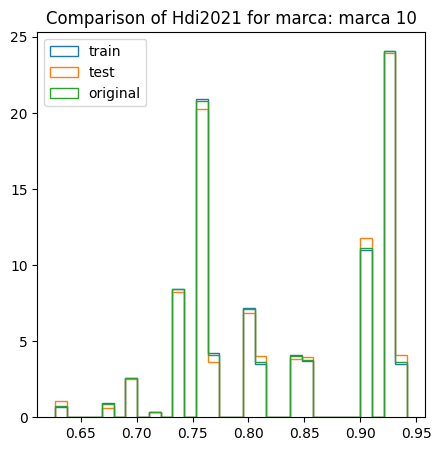

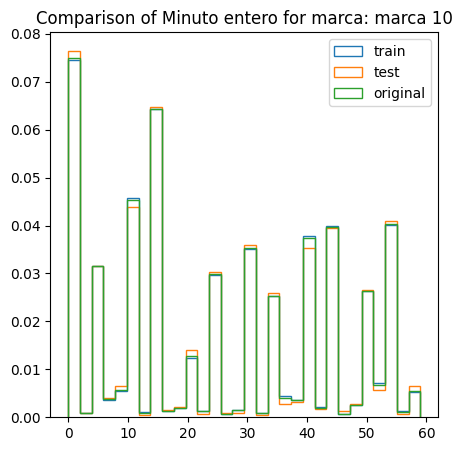

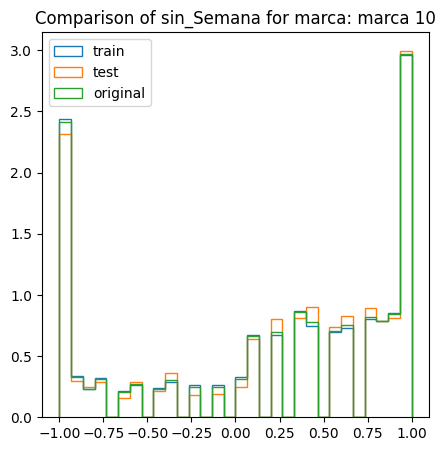

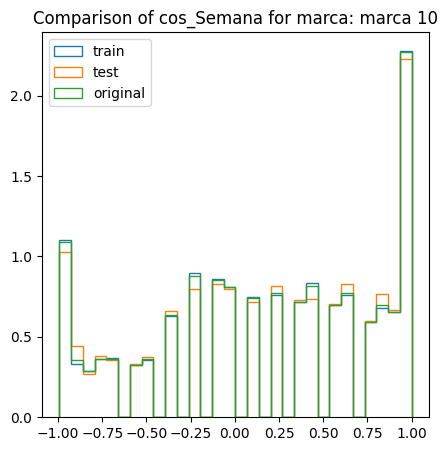

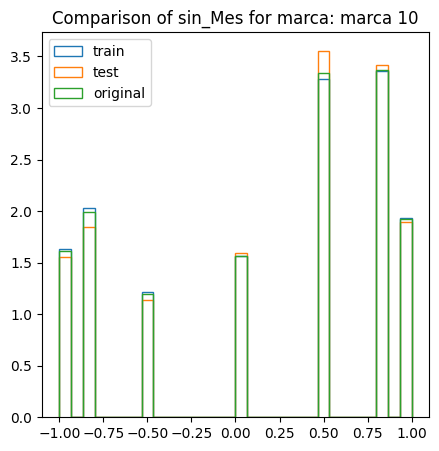

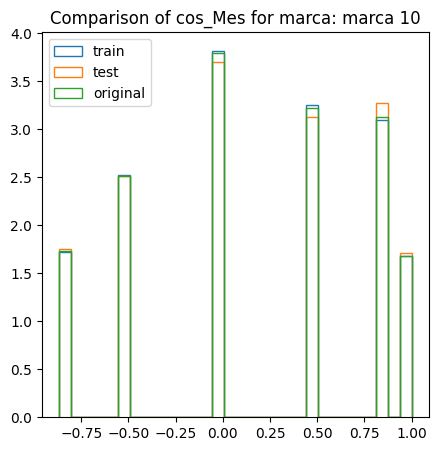

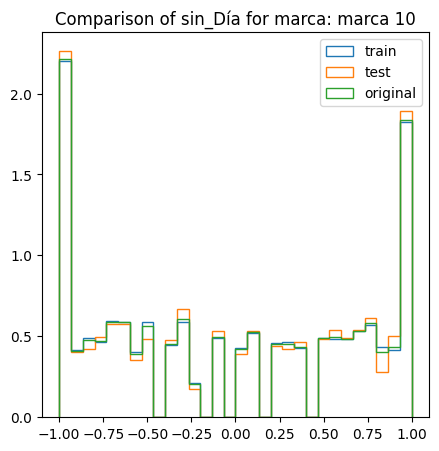

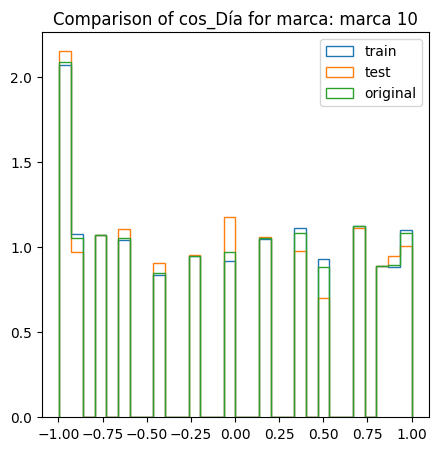

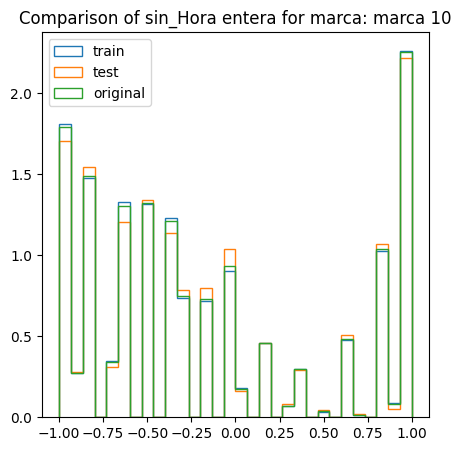

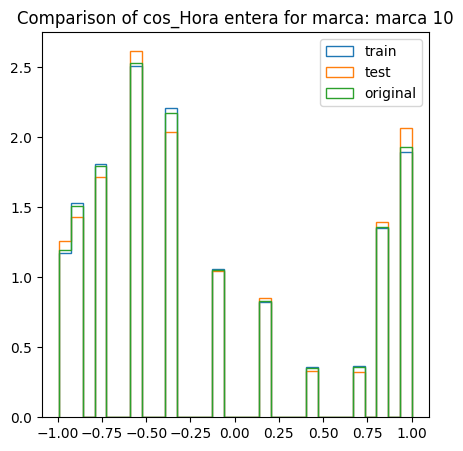

Train statistics


,Hora entera,Pasajeros saliendo,Semana,Mes,Día,Hdi2021,Minuto entero,sin_Semana,cos_Semana,sin_Mes,cos_Mes,sin_Día,cos_Día,sin_Hora entera,cos_Hora entera
count,10525.000000,10525.000000,10525.000000,10525.000000,10525.000000,10525.000000,10525.000000,10525.000000,10525.000000,10525.000000,1.052500e+04,10525.000000,10525.000000,10525.000000,10525.000000
mean,13.865368,161.910736,23.247031,5.791449,16.081045,0.830864,25.364561,0.196823,0.173284,0.165843,2.006959e-01,-0.028900,-0.041203,-0.142053,-0.174399
std,5.606661,48.253513,15.804703,3.633971,8.663149,0.080038,18.640634,0.727589,0.633984,0.744262,6.151255e-01,0.712998,0.699425,0.684115,0.693890
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.627000,0.000000,-1.000000,-0.992709,-1.000000,-8.660254e-01,-0.998717,-0.994869,-0.997669,-0.990686
25%,9.000000,128.000000,10.000000,3.000000,8.000000,0.758000,10.000000,-0.568065,-0.354605,-0.500000,-5.000000e-01,-0.724793,-0.758758,-0.730836,-0.775711
50%,14.000000,160.000000,19.000000,5.000000,16.000000,0.809000,25.000000,0.464723,0.239316,0.500000,6.123234e-17,0.000000,-0.050649,-0.398401,-0.334880
75%,18.000000,183.000000,40.000000,10.000000,24.000000,0.921000,40.000000,0.885456,0.748511,0.866025,8.660254e-01,0.724793,0.688967,0.631088,0.460065
max,23.000000,261.500000,52.000000,12.000000,31.000000,0.942000,59.000000,1.000000,1.000000,1.000000,1.000000e+00,0.998717,1.000000,0.997669,1.000000


Test statistics


,Hora entera,Pasajeros saliendo,Semana,Mes,Día,Hdi2021,Minuto entero,sin_Semana,cos_Semana,sin_Mes,cos_Mes,sin_Día,cos_Día,sin_Hora entera,cos_Hora entera
count,2632.000000,2632.000000,2632.000000,2632.000000,2632.000000,2632.000000,2632.000000,2632.000000,2632.000000,2632.000000,2632.000000,2632.000000,2632.000000,2632.000000,2632.000000
mean,13.971505,162.310790,22.411474,5.602204,15.998480,0.832842,25.173632,0.226009,0.175699,0.194019,0.207500,-0.020719,-0.059912,-0.133529,-0.158011
std,5.675062,47.850878,15.581072,3.590313,8.550829,0.080747,18.709584,0.717064,0.635781,0.730745,0.621017,0.716845,0.694618,0.679076,0.704573
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.627000,0.000000,-1.000000,-0.992709,-1.000000,-0.866025,-0.998717,-0.994869,-0.997669,-0.990686
25%,9.000000,128.000000,9.000000,3.000000,9.000000,0.758000,10.000000,-0.464723,-0.354605,-0.500000,-0.500000,-0.724793,-0.758758,-0.730836,-0.775711
50%,14.000000,161.000000,18.000000,5.000000,16.000000,0.823500,25.000000,0.464723,0.239316,0.500000,0.500000,0.000000,-0.050649,-0.334099,-0.334880
75%,18.000000,183.000000,39.000000,9.000000,23.000000,0.921000,40.000000,0.885456,0.748511,0.866025,0.866025,0.724793,0.688967,0.631088,0.682553
max,23.000000,261.500000,52.000000,12.000000,31.000000,0.942000,59.000000,1.000000,1.000000,1.000000,1.000000,0.998717,1.000000,0.997669,1.000000


Original statistics


,Hora entera,Pasajeros saliendo,Semana,Mes,Día,Hdi2021,Minuto entero,sin_Semana,cos_Semana,sin_Mes,cos_Mes,sin_Día,cos_Día,sin_Hora entera,cos_Hora entera
count,13157.000000,13157.000000,13157.000000,13157.000000,13157.000000,13157.000000,13157.000000,13157.000000,13157.000000,13157.000000,1.315700e+04,13157.000000,13157.000000,13157.000000,13157.000000
mean,13.886600,161.990765,23.079881,5.753591,16.064528,0.831260,25.326366,0.202662,0.173767,0.171480,2.020571e-01,-0.027263,-0.044946,-0.140347,-0.171120
std,5.620355,48.171690,15.763176,3.625934,8.640537,0.080181,18.653891,0.725563,0.634320,0.741636,6.162908e-01,0.713749,0.698480,0.683093,0.696044
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.627000,0.000000,-1.000000,-0.992709,-1.000000,-8.660254e-01,-0.998717,-0.994869,-0.997669,-0.990686
25%,9.000000,128.000000,10.000000,3.000000,9.000000,0.758000,10.000000,-0.568065,-0.354605,-0.500000,-5.000000e-01,-0.724793,-0.758758,-0.730836,-0.775711
50%,14.000000,160.000000,19.000000,5.000000,16.000000,0.809000,25.000000,0.464723,0.239316,0.500000,6.123234e-17,0.000000,-0.050649,-0.398401,-0.334880
75%,18.000000,183.000000,40.000000,10.000000,24.000000,0.921000,40.000000,0.885456,0.748511,0.866025,8.660254e-01,0.724793,0.688967,0.631088,0.460065
max,23.000000,261.500000,52.000000,12.000000,31.000000,0.942000,59.000000,1.000000,1.000000,1.000000,1.000000e+00,0.998717,1.000000,0.997669,1.000000


KS test statistics


,col,ks_statistic,ks_pvalue
0,Hora entera,0.013907,0.804848
1,Pasajeros saliendo,0.011855,0.925329
2,Semana,0.027089,0.089407
3,Mes,0.022224,0.245887
4,Día,0.016970,0.573353
5,Hdi2021,0.018088,0.490756
6,Minuto entero,0.008740,0.996704
7,sin_Semana,0.029652,0.048387
8,cos_Semana,0.010740,0.966237
9,sin_Mes,0.022224,0.245887


****************************************************************************************************
****************************************************************************************************








In [32]:
for marca, df_marca in datasets.items():
    analyze_marca_splits(
        marca,
        df_marca,
        NUMERICAL_COLUMNS
    )